# Setup

In [7]:
# Essential libraries
import os
import random
import itertools
from itertools import product, combinations
import multiprocessing
import math

# Numeric computation
import numpy as np
import torch
from scipy.linalg import cholesky  # For linear algebra (e.g., Cholesky decomposition)
from scipy.spatial import ConvexHull, Delaunay # For sampling and NTR
from scipy.optimize import minimize #For projection to the NTR
from scipy.spatial.distance import pdist, squareform #For projection to the NTR
# from scipy.special import roots_hermite # Polynomials of the form e^(-x^2)
# from scipy.special import roots_hermitenorm # Polynomials of the form e^(-x^(2)/2)
from scipy.optimize import least_squares
# Gaussian Process Regression (GPR)
import gpytorch
from gpytorch.models import ExactGP, ApproximateGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import (Kernel, ScaleKernel, MaternKernel, 
                              GridInterpolationKernel, ProductKernel)
# from gpytorch.utils.grid import choose_grid_size
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from torch.nn import ModuleList  # Correct import for ModuleList (For SKIP)
# from gpytorch.lazy import MatmulLazyTensor, InterpolatedLazyTensor

from gpytorch.settings import fast_computations, lazily_evaluate_kernels, detach_test_caches, skip_posterior_variances
# from gpytorch.settings import fast_pred_var, fast_pred_samples

# Optimization
import cyipopt
from cyipopt import Problem

# Quasi-Monte Carlo (QMC) and sparse grids
# import Tasmanian  # Tasmanian Sparse Grid library
from Tasmanian import makeGlobalGrid
from torch.quasirandom import SobolEngine
import chaospy as cp

# We can save our No-trade-regions (Convex hulls) as .pkl files
import pickle
    #Save
    # with open("convex_hulls_array.pkl", "wb") as file:
    #     pickle.dump(convex_hulls, file)
    #Open
    # with open("convex_hulls_array.pkl", "rb") as file:
    #     loaded_hulls = pickle.load(file)

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
import scienceplots  # For custom style based on science plots

# Parallel processing
from joblib import Parallel, delayed

# Logging configuration
import logging
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
import gc # Garbage collector
# Random seed setup
random_seed = 100598
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
multiprocessing.set_start_method('spawn', force=True)

## Designing a custom plotting style and updating scienceplots

In [8]:
plt.style.use('science')

custom = True
if custom:

    colors = ['#094a84','#cc2300', 
                '#009437', '#cc7700',
                '#694878', '#383838',
                '#7e7e7e']
    mpl.rcParams['axes.prop_cycle'] = cycler('color', 
                                            ['#094a84','#cc2300', 
                                            '#009437', '#cc7700',
                                            '#694878', '#383838',
                                            '#7e7e7e'])

    mpl.rcParams['figure.facecolor'] = '#ffffff'  # Lightest Snow Storm background
    mpl.rcParams['axes.facecolor'] = '#FCFDFE'    # Same light background inside plots
    mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.facecolor'] = '#3B4252'    # Same light background inside plots
    # # mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.edgecolor'] = '#3B4252'    # Dark Slate from Polar Night for edges
    # mpl.rcParams['axes.labelcolor'] = '#3B4252'   # Text color for labels using Dark Slate
    # mpl.rcParams['xtick.color'] = '#3B4252'       # Tick color from Polar Night palette
    # mpl.rcParams['ytick.color'] = '#3B4252'

    mpl.rcParams['font.size'] = 11
    mpl.rcParams['axes.titlesize'] = 11
    mpl.rcParams['axes.labelsize'] = 11
    mpl.rcParams['legend.fontsize'] = 11

    # Remove spines
    # mpl.rcParams['axes.spines.top'] = False
    # mpl.rcParams['axes.spines.right'] = False
    # mpl.rcParams['axes.spines.bottom'] = False
    # mpl.rcParams['axes.spines.left'] = False

    # Grid settings
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.color'] = '#e2e3e4'        # Subtle grid lines using light Snow Storm color
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.8
    mpl.rcParams['axes.titlecolor'] = 'black'
    # Ticks
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'

    # Lines and markers
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['lines.markeredgewidth'] = 1.5

    # Legends
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'

    # Subplots and layout
    mpl.rcParams['figure.figsize'] = [8, 6]
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.autolayout'] = True

    # Always save as 'tight'
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.02

    # Save figures to the folder Figures
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)

## Main Code Block

ISNAN warning probably stems from my bellman (pi_t1 or xt1).
Need to ensure these are tensors

In [9]:
import torch.jit


**NOTE** : Code takes longer for bigger tau

In [10]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

# Set print options
torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True, precision=4)

# Limit PyTorch and NumPy to use a single thread per worker
torch.set_num_threads(1)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

def TasmanianSGLogQuadNorm(n, mu=None, cov=None):
    """
    Computes nodes and weights for a multivariate normal distribution
    using Tasmanian's Gauss-Hermite quadrature. (Same as Schober 2022 uses)

    Args:
        n (list or array-like): 1 by d array of number of refinements (nodes) per dimension.
        mu (array-like): 1 by d mean vector. Defaults to zeros.
        cov (array-like): d by d covariance matrix. Defaults to identity.

    Returns:
        tuple:
            - x (np.ndarray): Matrix of evaluation nodes (num_nodes x d). Exponential transformed.
            - w (np.ndarray): Array of quadrature weights (num_nodes,).
    """
    n = np.asarray(n)
    dim = n.size

    # Default covariance matrix
    if cov is None:
        cov = np.eye(dim)
    else:
        cov = np.asarray(cov)
        if cov.shape != (dim, dim):
            raise ValueError("Covariance matrix must be of shape (d, d).")

    # Default mean vector
    if mu is None:
        mu = np.zeros(dim)
    else:
        mu = np.asarray(mu)
        if mu.size != dim:
            raise ValueError("Mean vector must be of length d.")

    # Calculate anisotropic refinements
    if dim == 1:
        refine = []
    else:
        refine = (1.0 / np.array(n) * np.prod(n)).tolist()

    # Determine the maximum level
    level = int(np.max(n))

    # Create Tasmanian grid using positional arguments
    grid = makeGlobalGrid(
        int(dim),              # iDimension
        1,                     # iOutputs
        level,                 # iDepth
        'level',               # sType
        'gauss-hermite',       # sRule
        refine,                # liAnisotropicWeights 
        0.0,                   # fAlpha #No alpha for Gauss-Hermite
        0.0,                   # fBeta #No beta for Gauss-Hermite
        "",                    # sCustomFilename
        []                     # liLevelLimits
    )

    # Retrieve nodes and weights
    nodes = grid.getPoints()    # Shape: (dim, num_nodes)
    weights = grid.getQuadratureWeights() # Shape: (num_nodes,)
    
    # Transpose nodes to shape (num_nodes, dim)
    # nodes = nodes.              # Now nodes.shape = (num_nodes, dim)
    # nodes *= np.sqrt(2) # Correct scaling by sqrt(2)

    L = cholesky(cov, lower=True).T  # Shape: (dim, dim)
    transformed_nodes = mu*Delta_t + np.sqrt(2) * np.sqrt(Delta_t) * (nodes @ L)  # Shape: (num_nodes, dim)
    transformed_nodes = np.exp(transformed_nodes-0.5*np.diag(cov)*Delta_t)  # Transform to positive domain
    scaled_weights = (np.pi ** (-dim / 2)) * weights  # Shape: (num_nodes,)

    return transformed_nodes, scaled_weights,L

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(          
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1])
            # ,jitter=1e-8  # Adding jitter for numerical stability
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y, patience=100, min_delta=1e-7, max_iterations=1000):
    """
    Trains a Gaussian Process Regression model with early stopping.

    Args:
        train_x (torch.Tensor): Training inputs. Shape: [num_samples, D]
        train_y (torch.Tensor): Training targets. Shape: [num_samples]
        patience (int): Number of iterations to wait for improvement before stopping.
        min_delta (float): Minimum change in the loss to qualify as an improvement.
        max_iterations (int): Maximum number of iterations to run.

    Returns:
        model (GPRegressionModel): Trained GP model.
        likelihood (gpytorch.likelihoods.GaussianLikelihood): Associated likelihood.
    """
    if train_y.dim() > 1:
        train_y = train_y.squeeze(-1)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        # This is an assumption of noise in training data. See Murphy(2023) 18.3.1
        noise_constraint=gpytorch.constraints.Interval(1e-12, 1e-6)
    )
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float('inf')
    no_improvement_count = 0

    for i in range(max_iterations):
        optimizer.zero_grad()
        # with gpytorch.settings.cholesky_jitter(1e-5):
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()

        # Check for improvement
        if current_loss < best_loss - min_delta:
            best_loss = current_loss
            no_improvement_count = 0  # Reset the counter if we see improvement
        else:
            no_improvement_count += 1  # Increment if no improvement

        # Early stopping condition
        if no_improvement_count >= patience:
            print(f"Early stopping at iteration {i+1}")
            break
    
    # After training
    del optimizer, mll
    del train_x, train_y, output, loss
    # torch.cuda.empty_cache()  # If using CUDA    
      # Garbage collection
    return model, likelihood

def utility(var, gamma):
    # var = torch.clamp(var, min=1e-4)
    if gamma == 1:
        return torch.log(var)  # Log utility for gamma = 1
    else:
        return (var ** (1.0 - gamma)) / (1.0 - gamma)  # CRRA utility      #Which is correct?

def V_terminal(xT, tau, fc, gamma, Rf, Delta_t):
    r = np.log(Rf)
    # Ensure xT requires grad
    holdings = 1.0 - tau * torch.sum(xT, dim=-1) - fc
    terminal_utility = ((holdings ** (1.0 - gamma)) * Delta_t) / (1.0 - gamma)
    # return terminal_utility #(if using vt as value function)
    return holdings # (if using jt as value function)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau, fc=0.0, Delta_t=1.0, ct=None, include_consumption=False):
    # This function is more similar to Schober 2022
    if not include_consumption:
        ct = torch.tensor([0.0], dtype=torch.float64)
    # if ct is None:
    #     ct = torch.tensor([0.0], dtype=torch.float64)

    # Ensure ct is a scalar tensor
    if ct.dim() == 0:
        ct = ct  # Already scalar
    else:
        ct = ct.squeeze()  # Convert [1] to scalar tensor []

    # # if torch sum xt > 1 then normalize it
    # if torch.sum(xt) > 1:
    #     xt = xt / torch.sum(xt)
        
    # Available cash before transactions
    available_cash = 1.0 - torch.sum(xt)

    # Buying and selling costs
    buying_cost = (1.0 + tau) * torch.sum(delta_plus)
    selling_proceeds = (1.0 - tau) * torch.sum(delta_minus)

    # Calculate bond holdings (bt)
    bt = available_cash - buying_cost + selling_proceeds - torch.sum(ct) * Delta_t - fc
    bt = torch.abs(bt)  # Ensure bond holdings are non-negative
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau):
    """
    Handles both single and batched Rt inputs.

    Args:
        xt (torch.Tensor): Current state allocations. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        Rt (torch.Tensor): Returns. Shape: [D] or [n_samples, D]
        bt (torch.Tensor or float): Bond holdings.
        Rf (float): Risk-free rate factor.
        tau (float): Transaction cost rate.

    Returns:
        pi_t1 (torch.Tensor): Next period's portfolio value. Shape: [1] or [n_samples]
        xt1 (torch.Tensor): Next period's state allocation proportions. Shape: [D] or [n_samples, D]
        Wt1 (torch.Tensor): Wealth factor (scalar or [n_samples])
    """
    # Convert inputs to tensors if necessary
    if not torch.is_tensor(bt):
        bt = torch.tensor(bt, dtype=torch.float64)
    if not torch.is_tensor(Rf):
        Rf = torch.tensor(Rf, dtype=torch.float64)

    # Squeeze the first dimension if necessary
    xt = xt.squeeze(0)          # Shape: [D]
    delta_plus = delta_plus.squeeze(0)    # Shape: [D]
    delta_minus = delta_minus.squeeze(0)  # Shape: [D]

    # Calculate asset adjustments
    asset_adjustment = xt + delta_plus - delta_minus  # Shape: [D]

    # Check if Rt is batched
    if Rt.dim() == 1:
        # Single Rt
        portfolio_returns = asset_adjustment * Rt  # Shape: [D]
        pi_t1 = bt * Rf + torch.sum(portfolio_returns)  # Scalar (float)
        pi_t1 = torch.tensor(pi_t1, dtype=torch.float64)  # Ensure tensor
        xt1 = portfolio_returns / pi_t1  # Shape: [D]
        Wt1 = pi_t1  # Scalar
    else:
        # Batched Rt
        # Rt: [n_samples, D]
        portfolio_returns = asset_adjustment.unsqueeze(0) * Rt  # Shape: [n_samples, D]
        pi_t1 = bt * Rf + torch.sum(portfolio_returns, dim=1)   # Shape: [n_samples]
        xt1 = portfolio_returns / pi_t1.unsqueeze(1)  # Shape: [n_samples, D]
        Wt1 = pi_t1  # Shape: [n_samples]

    return pi_t1, xt1

# my Bellman. Which includes the certainty equivalent transformation
def bellman_equation(
    vt_next_in,
    vt_next_out,
    xt,
    delta_plus,
    delta_minus,
    beta,
    gamma,
    Delta_t,
    tau,
    fc,
    Rf,
    ct=None,
    include_consumption=False,
    convex_hull=None,
    t=None,
    mu=None,
    Sigma=None,
    quadrature_nodes_weights=None,
    integration_method='quadrature',
    num_mc_samples=1000  # Number of Monte Carlo samples if using MC integration
):
    """
    Computes the value function vt using the Bellman equation with specified integration method.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        xt (torch.Tensor): Current state. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        Delta_t (float): Time step size.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        ct (torch.Tensor or None): Consumption at time t.
        include_consumption (bool): Flag to include consumption.
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        t (int): Current time step.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        quadrature_nodes_weights (tuple or None): Quadrature nodes and weights.
        integration_method (str): 'quadrature' or 'monte_carlo'
        num_mc_samples (int): Number of Monte Carlo samples (used if integration_method='monte_carlo')

    Returns:
        torch.Tensor: Value function. Shape: [1]
    """
    D = len(mu)
    assert xt.dim() == 2 and xt.size(0) == 1, f"xt must be [1, D], got {xt.shape}"
    assert delta_plus.dim() == 2 and delta_plus.size(0) == 1, f"delta_plus must be [1, D], got {delta_plus.shape}"
    assert delta_minus.dim() == 2 and delta_minus.size(0) == 1, f"delta_minus must be [1, D], got {delta_minus.shape}"
    if not include_consumption:
        ct = torch.tensor([0.0], dtype=torch.float64)  # Shape: [1]

    # if include consumption make sure it is a tensor and make sure it is 0 dimensional
    if include_consumption:
        if not torch.is_tensor(ct):
            ct = torch.tensor(ct, dtype=torch.float64)
        if ct.dim() == 1:
            ct = ct.squeeze(0)

    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, fc, Delta_t, ct, include_consumption)
        # # # if bt is negative but less than 1e-3, set it to 0
    if bt < 0 and bt > -1e-3:
        bt = torch.tensor([0.0], dtype = torch.float64)
        # if bt <0 raise error and display xt delta_plus delta_minus

    # if bt < 0:
    #     return torch.tensor([-100000], dtype=torch.float64, requires_grad=True)

    if bt < -1e-3:
        raise ValueError(f"bond holdings are negative. bt: {bt}")

    if integration_method == 'quadrature':
        # Quadrature integration
        # Check if quadrature nodes and weights are provided; if not, compute them
        if quadrature_nodes_weights is None:
            raise ValueError("No quadrature nodes and weights provided.")
        # else:
        transformed_nodes, weights, L = quadrature_nodes_weights

        # Convert to torch tensors
        log_nodes = torch.tensor(transformed_nodes, dtype=torch.float64)  # Shape: [n_q^D, D]
        weights = torch.tensor(weights, dtype=torch.float64)          # Shape: [n_q^D]

        pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, log_nodes, bt, Rf, tau)

    elif integration_method == 'monte_carlo':
        random_seed = 20011210
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        # Monte Carlo integration
        adjusted_mu = mu* Delta_t  - 0.5 * np.diag(Sigma) * Delta_t #See Cai Judd Xu 2013
        distribution = cp.MvNormal(adjusted_mu, Sigma * Delta_t)
        samples = distribution.sample(num_mc_samples, rule='random')
        log_Rt_samples = torch.tensor(samples.T, dtype=torch.float64)  # Shape: [num_mc_samples, D]
        Rt = torch.exp(log_Rt_samples)
        pi_t1, xt1, Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)
        pi_t1, xt1, Wt1 = [], [], []
        for node in Rt:
            pi, x, W = normalized_state_dynamics(xt, delta_plus, delta_minus, node, bt, Rf, tau)
            pi_t1.append(pi)
            xt1.append(x)
            Wt1.append(W)
        pi_t1 = torch.stack(pi_t1)  # Shape: [n_q^D]
        xt1 = torch.stack(xt1)      # Shape: [n_q^D, D]
        Wt1 = torch.stack(Wt1)      # Shape: [n_q^D]

    elif integration_method == 'quasi_monte_carlo':
        random_seed = 20011210
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        # Quasi-Monte Carlo integration using Sobol sequences
        adjusted_mu = mu * Delta_t - 0.5 * np.diag(Sigma) * Delta_t #See Cai Judd Xu 2013
        distribution = cp.MvNormal(adjusted_mu, Sigma * Delta_t)
        samples = distribution.sample(num_mc_samples, rule='sobol')  # 'sobol' or 'halton'
        log_Rt_samples = torch.tensor(samples.T, dtype=torch.float64)  # Shape: [num_mc_samples, D]
        Rt = torch.exp(log_Rt_samples)

        pi_t1, xt1, Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)
    else:
        raise ValueError("Invalid integration method. Choose 'quadrature', 'monte_carlo', or 'quasi_monte_carlo'.")

    # Raise error if NaN or Inf values are encountered
    # if torch.isnan(pi_t1).any() or torch.isnan(xt1).any():
    if torch.isnan(pi_t1).any() or torch.isnan(xt1).any():
        raise ValueError("NaN values encountered in pi_t1, xt1.")

    # if any xt is very slightly negative, set it to 0
    if ((xt1 < 0) & (xt1 > -1e-4)).any():
        xt1[(xt1 < -0.0) & (xt1 > -1e-5)] = 0.0



    # Correctly expand delta_plus and delta_minus to match xt1's shape
    delta_plus_expanded = delta_plus.repeat(xt1.size(0), 1)    # Shape: [n_samples, D]
    delta_minus_expanded = delta_minus.repeat(xt1.size(0), 1)  # Shape: [n_samples, D]

    # Determine if next state is inside NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(xt1, convex_hull, delta_plus_expanded, delta_minus_expanded,epsilon_ntr=1e-6, t=t)  # [n_samples]
        # in_ntr = is_in_ntr(xt1, convex_hull)  # [n_samples]

    # Evaluate the next period's value function
    vt_next_vals = torch.zeros(xt1.size(0), dtype=torch.float64)

    # Find points inside and outside the NTR given out decision and return and NTR
    xt1_in = xt1[in_ntr] if in_ntr.any() else torch.empty((0, D), dtype=torch.float64, device=xt.device)
    xt1_out = xt1[~in_ntr] if (~in_ntr).any() else torch.empty((0, D), dtype=torch.float64, device=xt.device)

    # Select corresponding value function and predict
    #gpytorch.settings.fast_pred_var()

    # Define a function for GP mean prediction
    if isinstance(vt_next_in, gpytorch.models.ExactGP) or isinstance(vt_next_out, gpytorch.models.ExactGP):
        vt_next_in.eval()
        vt_next_out.eval()
        with torch.no_grad(), \
        fast_computations(covar_root_decomposition=True,log_prob=True, solves=True),\
        skip_posterior_variances(state=True): 
                xt1_in = xt1_in.unsqueeze(0) if xt1_in.dim() == 1 else xt1_in
                xt1_out = xt1_out.unsqueeze(0) if xt1_out.dim() == 1 else xt1_out
                vt_next_val_out = vt_next_out(xt1_out).mean.squeeze()
                vt_next_val_in = vt_next_in(xt1_in).mean.squeeze()  # [n_in]
                # Replace explicit loops with tensor operations
        vt_next_vals = torch.where(
            in_ntr,
            vt_next_in(xt1).mean.squeeze(),
            vt_next_out(xt1).mean.squeeze()
        )
            
    else:
        vt_next_val_in = V_terminal(xt1_in, tau, fc, gamma, Rf, Delta_t).squeeze()  # [n_in]
        vt_next_val_out = V_terminal(xt1_out, tau, fc, gamma, Rf, Delta_t).squeeze()  # [n_out]
        vt_next_vals[in_ntr] = vt_next_val_in
        vt_next_vals[~in_ntr] = vt_next_val_out

    # if any negative elements in vt_next_vals, set them them positive
    # if (vt_next_vals > 0).any():
    #     vt_next_vals[vt_next_vals > 0] = vt_next_vals[vt_next_vals > 0]*(-1)

    if integration_method == 'quadrature':
        # expected_vt = torch.sum( (((pi_t1) ** (1.0 - gamma)) * vt_next_vals) * weights )
        # expected_vt = torch.sum(((pi_t1) ** (1.0 - gamma))*weights)*torch.sum(vt_next_vals*weights)

        expected_vt = torch.sum( (((pi_t1) ** (1.0 - gamma)) * vt_next_vals) * weights )
        # expected_vt = torch.sum(((pi_t1) ** (1.0 - gamma))*weights)*torch.sum(vt_next_vals*weights)

        expected_vt_weighted = expected_vt #NOTE Scaling weights. See Hoerneff 2016
    elif integration_method == 'monte_carlo':
        vt_i = (pi_t1 ** (1.0 - gamma)) * vt_next_vals
        expected_vt = torch.sum(vt_i / num_mc_samples)

    elif integration_method == 'quasi_monte_carlo':
        vt_i = (pi_t1 ** (1.0 - gamma)) * vt_next_vals
        expected_vt = torch.sum(vt_i / num_mc_samples)

    vt = beta * expected_vt_weighted  # Shape: [1]
    if include_consumption:
        # vt = vt.view(-1)  # Ensure vt is a 1D tensor
        vt += utility(ct, gamma) * Delta_t # Shape: [1]
        # vt = vt.unsqueeze(0)

    # # NOTE Certainty equivalent transformation from Shober 2022 (Same result actually) (see exponents which cancel...)
    # Compute valueFunctionExpectation = E[(valueFunction)^(1 - gamma)]
    valueFunction = pi_t1 * vt_next_vals  # Wealth times next period's value
    valueFunctionPower = valueFunction ** (1.0 - gamma)
    expected_jt = torch.sum(valueFunctionPower * weights)
    expected_jt *= (1 / (np.pi ** (D / 2)))  # Scaling weights if necessary

    jt = beta * expected_jt #**(1.0/(1.0-gamma))

    if include_consumption:
        jt += ct**(1-gamma) # Shape: [1]

    jt = jt**(1.0/(1.0-gamma))
    # Ensure the result is a tensor
    if not torch.is_tensor(vt):
        vt = torch.tensor(vt, dtype=torch.float64)
    
    # Delete large tensors before returning
    del pi_t1, xt1, vt_next_vals
    if 'Rt' in locals():
        del Rt
    if 'valueFunction' in locals():
        del valueFunction
    if 'valueFunctionPower' in locals():
        del valueFunctionPower
    if 'delta_plus_expanded' in locals():
        del delta_plus_expanded
    if 'delta_minus_expanded' in locals():
        del delta_minus_expanded

    
    return jt

# Sample points which are in Scheiddegger
def sample_state_points(D, max_points=32):
    points = []

    # Add the zero row
    points.append([0.0] * D)

    # Add rows with a single 1 and the rest zeros
    for i in range(D):
        row = [0.0] * D
        row[i] = 1.0
        points.append(row)

    # Add combinations of rows with values 1/d, summing to 1
    for d in range(2, D + 1):
        value = 1.0 / d
        for indices in combinations(range(D), d):
            row = [0.0] * D
            for idx in indices:
                row[idx] = value
            points.append(row)

    # Recursive midpoint generation
    def generate_midpoints(current_points):
        new_points = set()  # Use a set to avoid duplicates
        for i in range(len(current_points)):
            for j in range(i + 1, len(current_points)):
                # Compute the midpoint
                midpoint = [
                    0.5 * (current_points[i][k] + current_points[j][k])
                    for k in range(D)
                ]
                # Only add valid midpoints
                if sum(midpoint) == 1.0 or any(coord == 0.0 for coord in midpoint):
                    new_points.add(tuple(midpoint))  # Use tuple for set compatibility
        return list(new_points)

    # Perform midpoint generation until no new points are added or max_points is reached
    all_points = set(tuple(point) for point in points)  # Start with initial points
    while len(all_points) < max_points:
        current_points = list(all_points)
        midpoints = generate_midpoints(current_points)
        new_points = set(midpoints)
        if not new_points - all_points:  # Stop if no new points are found
            break
        all_points.update(new_points)
        if len(all_points) >= max_points:
            break

    # Limit the number of points to max_points
    limited_points = sorted(list(all_points))

    # Convert back to a tensor
    points_tensor = torch.tensor(limited_points, dtype=torch.float64)

    return points_tensor

def sample_state_points_with_pattern(D, max_points=None,include_consumption=False, c_min=1e-8):
    if max_points is None:
        max_points = (1/2)*(D**2+3*D) + 2**D + D + 1 # add a few extra points to ensure we have enough
        max_points = 2**D+D+D+2 # add a few extra points to ensure we have enough
        max_points = int(max_points)
    points = []

    # 1. Add the zero row
    if not include_consumption:
        zero_row = [[0.0] * D]
    else:
        zero_row = [[0.0] * D]

    # 2. Add rows with a single 1 and the rest zeros
    single_rows = []
    for i in range(D):
        row = [0.0] * D
        row[i] = 1.0
        single_rows.append(row)

    # 3. Add combinations of rows with values 1/d, summing to 1
    combination_rows = []
    for d in range(2, D + 1):
        value = 1.0 / d
        for indices in combinations(range(D), d):
            row = [0.0] * D
            for idx in indices:
                row[idx] = value
            combination_rows.append(row)

    # 3.5 Generate mid points on each axis
    middle_axis_points = []
    for i in range(D):
        row = [0.0] * D
        row[i] = 0.5  # Random value along each dimension. Avoid 0 and 1 since we have these
        middle_axis_points.append(row)
    def distance(point1, point2):
        """Calculate the Euclidean distance between two points."""
        return math.sqrt(sum((a - b) ** 2 for a, b in zip(point1, point2)))

    # 4. Generate random points along each dimension and points summing to 1
    def generate_axis_random_points():
        while True:
            for i in range(D):
                while True:
                    row = [0.0] * D
                    row[i] = random.uniform(0.15, 0.85)  # Random value along each dimension
                    if abs(row[i] - 0.5) >= 0.055:  # Ensure the point is not too close to 0.5
                        yield row
                        break

    def generate_sum_to_one_points():
        while True:
            values = [random.random() for _ in range(D)]
            total = sum(values)
            row = [val / total for val in values]  # Normalize to sum to 1
            if distance(row, [0.5] * D) >= 0.055:  # Exclude points close to [0.5, 0.5]
                yield row

    random_axis_points = []
    random_sum_to_one_points = []
    axis_points_generator = generate_axis_random_points()
    sum_to_one_points_generator = generate_sum_to_one_points()

    # Generate random points alternately until max_points is reached
    while len(zero_row) + len(single_rows) + len(combination_rows) + len(middle_axis_points) + len(random_axis_points) + len(random_sum_to_one_points) < max_points:
        try:
            random_axis_points.append(next(axis_points_generator))
        except StopIteration:
            pass

        if len(zero_row) + len(single_rows) + len(combination_rows) + len(middle_axis_points) + len(random_axis_points) + len(random_sum_to_one_points) < max_points:
            random_sum_to_one_points.append(next(sum_to_one_points_generator))

    # Combine all points in the required order
    combined_points = (
        zero_row
        + single_rows
        + combination_rows
        + middle_axis_points
        + random_axis_points[:max_points - len(zero_row) - len(single_rows) - len(combination_rows) - len(middle_axis_points)]
        + random_sum_to_one_points[:max_points - len(zero_row) - len(single_rows) - len(combination_rows) - len(middle_axis_points) -len(random_axis_points)]
    )

    # Convert to tensor
    points_tensor = torch.tensor(combined_points[:max_points], dtype=torch.float64)

    return points_tensor

# Functions for Sampling points in step 2.b (Solutions over the designed space)
def point_in_convex_hull(ellipse, point):
    """
    Check if a point is inside the circular convex hull.
    
    Args:
        ellipse (ellipse): Circle object defining the NTR.
        point (ndarray): Point to check, shape [2].
    
    Returns:
        bool: True if the point is inside the circle, False otherwise.
    """
    return ellipse.contains(point)

def create_grid(ellipse, grid_density=100):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1).

    Args:
        ellipse (EllipseConvexHull): My own class of elipse like objects which are the hull
        grid_density (int): Number of points along each dimension.

    Returns:
        ndarray: Grid of points inside the simplex.
    """
    D = ellipse.center.shape[0]  # Since we are working in 2D
    grid_ranges = [np.linspace(0, 1, grid_density) for _ in range(D)]
    mesh = np.meshgrid(*grid_ranges, indexing='ij')
    grid = np.stack(mesh, axis=-1).reshape(-1, D)
    simplex_mask = np.sum(grid, axis=1) <= 1
    points = grid[simplex_mask]
    return points
    
def create_grid_excluding_ntr(ellipse, D, grid_density=100):
    """
    Creates a grid inside the simplex, excluding points inside the ellipsoid.
    """
    grid_points = create_grid(ellipse, grid_density)
    mask = np.array([ellipse.contains(p) for p in grid_points])
    outside_points = grid_points[~mask]
    return outside_points

def sample_point_inside_ellipsoid(ellipse, D, max_attempts=5000):
    """
    Samples a point uniformly inside the ellipsoid:
        (x - c)^T A (x - c) <= 1
    Subject to x_i >= 0 and sum(x_i) <= 1.

    Tries up to max_attempts times to find a feasible point.
    """
    center = ellipse.center
    A = ellipse.A
    for _ in range(max_attempts):
        # Sample a random direction
        u = np.random.normal(size=D)
        norm = np.linalg.norm(u)
        if norm == 0:
            continue
        u = u / norm
        
        # Solve alpha so that (alpha*u)^T A (alpha*u) = 1
        val = u @ A @ u
        alpha = 1.0 / np.sqrt(val)
        
        # Random radius for uniform volume distribution
        # r in [0,1]^(1/D)
        r = np.random.uniform(0, 1)**(1.0/D)
        point = center + (alpha * r) * u

        # Check feasibility
        if np.all(point >= 0) and np.sum(point) <= 1:
            return point
    raise ValueError("Failed to sample a feasible inside point after many attempts.")

def sample_kink_points_on_ellipsoid(ellipse, D, num_kinks, max_attempts=10000):
    """
    Samples kink points around the ellipsoid boundary. Kink points:
    - Start from a point on the boundary (x - c)^T A (x - c) = 1.
    - Perturb outward and sideways.
    - Must lie outside the ellipsoid and satisfy simplex constraints.
    
    Args:
        ellipse (EllipsoidConvexHull): Ellipsoid defining the NTR.
        D (int): Dimension of the space.
        num_kinks (int): Number of kink points to sample.
        max_attempts (int): Global maximum number of attempts to find all kink points.
    
    Returns:
        np.array: Kink points outside the ellipsoid, shape (num_kinks, D).
    
    Raises:
        ValueError: If enough kink points cannot be found within max_attempts.
    """
    center = ellipse.center
    A = ellipse.A
    kink_points = []
    attempts = 0
    
    while len(kink_points) < num_kinks and attempts < max_attempts:
        attempts += 1
        
        # Sample a random direction on the unit sphere
        u = np.random.normal(size=D)
        norm_u = np.linalg.norm(u)
        if norm_u == 0:
            continue  # Resample if zero vector
        u /= norm_u
        
        # Check if direction is valid (A must be positive definite for a valid ellipsoid)
        try:
            val = u @ A @ u
            if val <= 0:
                continue  # Invalid direction, skip
        except:
            continue  # In case A is not positive definite
        
        # Find a boundary point
        alpha = 1.0 / np.sqrt(val)
        base_point = center + alpha * u  # Lies exactly on the ellipsoid boundary
        
        # Perturb outward
        # Maximum outward perturbation: 0.075 (7.5%)
        # Therefore, outward_scale ranges from 1.0 (no movement) to 1.075
        min_outward_scale = 1.035
        max_outward_scale = 1.125
        outward_scale = np.random.uniform(min_outward_scale, max_outward_scale)
        outward_distance = (outward_scale - 1.0) * alpha  # Distance to move outward
        outward = outward_distance * u
        
        # Perturb sideways: random orthogonal direction
        v = np.random.normal(size=D)
        v -= np.dot(v, u) * u  # Make orthogonal to u
        norm_v = np.linalg.norm(v)
        if norm_v < 1e-8:
            continue  # Cannot find a valid perpendicular direction, resample
        v /= norm_v
        
        # Sideways distance: between -0.03 and +0.03
        sideways_distance = np.random.uniform(-0.05 * alpha, 0.05 * alpha)
        sideways = sideways_distance * v
        
        # New kink point: move outward and sideways
        kink_candidate = base_point + outward + sideways
        
        # Check feasibility: outside ellipsoid and within simplex
        if ellipse.contains(kink_candidate):
            continue  # Still inside or on the boundary, reject
        if not (np.all(kink_candidate >= 0) and np.sum(kink_candidate) <= 1):
            continue  # Violates simplex constraints, reject
        
        # If all checks pass, accept the kink point
        kink_points.append(kink_candidate)
    
    if len(kink_points) < num_kinks:
        raise ValueError(f"Could not generate {num_kinks} kink points within {max_attempts} attempts.")
    
    return np.array(kink_points)

def sample_points_around_ntr_separated(ellipse, D, num_samples, kink_ratio=0.375, inside_ratio=0.15, grid_density=26, seed=None):
    """
    Samples points around the NTR (ellipsoid), inside the NTR, and outside (general points),
    ensuring all points are feasible: x_i >= 0, sum(x_i) <= 1.

    Args:
        ellipse (EllipsoidConvexHull): Ellipse defining the NTR.
        D (int): Dimension
        num_samples (int): Total number of samples.
        kink_ratio (float): Fraction of samples as kink points.
        inside_ratio (float): Fraction of samples inside the ellipse.
        grid_density (int): Grid density for general points.
        seed (int, optional): Seed for reproducibility.

    Returns:
        (inside_points, kink_points, general_points) as np arrays.
    """
    if seed is not None:
        np.random.seed(seed)

    num_inside = int(num_samples * inside_ratio)
    num_kinks = int(num_samples * kink_ratio)
    num_general = num_samples - num_inside - num_kinks

    # Sample inside points
    inside_points = []
    for _ in range(num_inside):
        p = sample_point_inside_ellipsoid(ellipse, D)
        inside_points.append(p)
    inside_points = np.array(inside_points) if num_inside > 0 else np.empty((0,D))

    # Sample kink points
    kink_points = sample_kink_points_on_ellipsoid(ellipse, D, num_kinks) if num_kinks > 0 else np.empty((0,D))

    # For general points: use the grid excluding NTR
    # These are already in the simplex. Filter out those inside ellipse.
    outside_points = create_grid_excluding_ntr(ellipse, D, grid_density)
    if num_general > 0:
        if len(outside_points) < num_general:
            raise ValueError("Not enough general points to sample from. Increase grid_density or reduce num_samples.")
        selected_indices = np.random.choice(len(outside_points), size=num_general, replace=False)
        general_points = outside_points[selected_indices]
    else:
        general_points = np.empty((0,D))

    return inside_points, kink_points, general_points

def is_in_ntr(x, ellipse, delta_plus=None, delta_minus=None, epsilon_ntr=1e-5, t=None):
    """
    Determines whether each point in x is inside the NTR (ellipse).

    Args:
        x (torch.Tensor): Points to check. Shape: [n_points, D]
        ellipse (EllipseConvexHull or None): Ellipse defining the NTR.
        delta_plus (torch.Tensor or None): Adjustments (increases). Shape: [n_points, D]
        delta_minus (torch.Tensor or None): Adjustments (decreases). Shape: [n_points, D]
        epsilon_ntr (float): Tolerance.
        t (int): Current time step.

    Returns:
        torch.Tensor: Boolean tensor indicating NTR membership. Shape: [n_points]
    """
    if ellipse is None:
        return torch.zeros(x.size(0), dtype=torch.bool, device=x.device)

    with torch.no_grad():
        # For each point, check (x_i - c)^T A (x_i - c) <= 1
        center = torch.tensor(ellipse.center, dtype=x.dtype, device=x.device)
        diff = x - center
        # Compute quadratic form for each x_i
        val = torch.einsum('ij,jk,ik->i', diff, torch.tensor(ellipse.A, dtype=x.dtype, device=x.device), diff)
        in_ellipse = val <= (1.0 + epsilon_ntr)

        if delta_plus is not None and delta_minus is not None:
            delta = delta_plus - delta_minus
            delta_policy = torch.all(torch.abs(delta) < epsilon_ntr, dim=-1)  # [n_points]
            return torch.logical_or(in_ellipse, delta_policy)
        
        return in_ellipse

# Function for projecting a point towards the NTR for initial guess
def project_onto_convex_hull(x, convex_hull):
    """
    Projects point x onto the convex hull defined by convex_hull (ellipse).
    If the point is outside the convex hull, it is projected to the center.
    If the point is inside, it remains unchanged.

    Args:
        x (np.array): Current position. Shape: [D]
        convex_hull (EllipseConvexHull): Elliptical convex hull.

    Returns:
        np.array: Projected point (center if outside, else the original point).
    """
    x = np.array(x)
    if convex_hull.contains(x):
        # Point is inside the convex hull; return it unchanged
        return x
    else:
        # Point is outside the convex hull; project it to the center
        return convex_hull.center.copy()

# Function for the Merton point (No costs solution)
def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1.0 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star

def fit_ellipsoid_matrix(center, edge_points):
    """
    Fit an ellipsoid (x - c)^T A (x - c) = 1 given edge points and a known center.
    Ensures A is positive definite by parameterizing A = L L^T.
    
    Args:
        center (np.array): Center of the ellipsoid, shape (D,).
        edge_points (np.array): Points on the boundary, shape (M, D).
    
    Returns:
        A (np.array): The fitted positive definite matrix (D x D).
    """
    D = center.shape[0]
    Q = edge_points - center  # (M, D)
    M = Q.shape[0]

    # Number of parameters for A (symmetric)
    num_params = D*(D+1)//2
    if M < num_params:
        raise ValueError("Not enough points to uniquely determine the ellipsoid.")
    
    # Parameterization: A = L L^T
    # We will optimize over the elements of L (lower-triangular)
    # Flatten L's lower-triangular part into a parameter vector
    def pack_L(L):
        return L[np.tril_indices(D)]
    
    def unpack_L(params):
        L = np.zeros((D,D), dtype=float)
        L[np.tril_indices(D)] = params
        return L

    # Objective function for least squares
    def residuals(params):
        L = unpack_L(params)
        A = L @ L.T
        # Compute Q_i^T A Q_i - 1 for each point
        vals = np.einsum('ij,jk,ik->i', Q, A, Q) - 1.0  # shape (M,)
        return vals

    # Initial guess: start with something simple like identity for A
    # So L could be identity as well
    L_init = np.eye(D)
    params_init = pack_L(L_init)

    result = least_squares(residuals, params_init, method='lm')  # Levenberg-Marquardt often works well

    if not result.success:
        raise ValueError("Ellipsoid fitting did not converge.")

    L_final = unpack_L(result.x)
    A = L_final @ L_final.T

    # Check positive definiteness
    eigvals = np.linalg.eigvalsh(A)
    if np.any(eigvals <= 0):
        raise ValueError("Fitted A is not positive definite.")
    
    return A

class EllipseConvexHull:
    def __init__(self, center, A):
        """
        Represents an elliptical convex region defined by:
        (x - center)^T A (x - center) <= 1
        
        Args:
            center (np.array): Center of the ellipse (D-dimensional).
            A (np.array): A positive definite symmetric matrix (D x D).
        """
        self.center = np.array(center)
        self.A = A  # Should be positive definite and symmetric

    def contains(self, point):
        """
        Check if a point is inside or on the boundary of the ellipse.

        (x - c)^T A (x - c) <= 1
        
        Args:
            point (np.array): D-dimensional point to check.
        
        Returns:
            bool: True if inside or on ellipse, False otherwise.
        """
        point = np.array(point)
        diff = point - self.center
        val = diff @ self.A @ diff
        return val <= 1.0

    def __repr__(self):
        return f"EllipseConvexHull(center={self.center}, A={self.A})"

def create_uniform_grid(dimensions, grid_density=70):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1).

    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        grid_density (int): Number of points along each dimension.

    Returns:
        ndarray: Grid of points inside the simplex.
    """
    D = dimensions
    grid_ranges = [np.linspace(0, 1, grid_density) for _ in range(D)]
    mesh = np.meshgrid(*grid_ranges, indexing='ij')
    grid = np.stack(mesh, axis=-1).reshape(-1, D)
    simplex_mask = np.sum(grid, axis=1) <= 1
    points = grid[simplex_mask]
    points_tensor = torch.tensor(points, dtype=torch.float64)
    return points_tensor

# Problem class for the optimization
class PortfolioOptimization(cyipopt.Problem):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        Delta_t,
        tau,
        fc,
        Rf,
        mu,
        Sigma,
        c_min,
        include_consumption=False,
        convex_hull=None,
        quadrature_nodes_weights=None,  # Added parameter
        integration_method='quadrature',
        num_mc_samples=1000,
        idx=None,
    ):
        self.D = D
        self.xt = xt.detach().clone()  # Shape: [1, D]
        self.vt_next_in = vt_next_in
        self.vt_next_out = vt_next_out
        self.t = t
        self.T = T
        self.beta = beta
        self.gamma = gamma
        self.Delta_t = Delta_t
        self.tau = tau
        self.fc = fc
        self.Rf = Rf
        self.mu = mu
        self.Sigma = Sigma
        self.c_min = c_min
        self.include_consumption = include_consumption
        self.convex_hull = convex_hull
        self.quadrature_nodes_weights = quadrature_nodes_weights  # Store quadrature data
        self.integration_method = integration_method
        self.num_mc_samples = num_mc_samples
        self.idx = idx
        self.epsilon_trade = 1e-3
        if not isinstance(xt, torch.Tensor):
            raise TypeError(f"xt must be a torch.Tensor, but got {type(xt)}")

        # **Define the number of variables (self.n)**
        self.n = 2 * D + (1 if self.include_consumption else 0)

        # **Define Constraint Count**
        # Constraints:
        # - 2 * D Asset Allocation Constraints (lower and upper bounds per asset)
        # - 2 Sum(x + delta) Constraints (sum >=0 and sum <=1)
        # - 1 Bond Holdings Constraint (bt >=0)
        # - 1 Consumption Constraint (c_t >= c_min) if included
        if self.include_consumption:
            self.m = 2 * D + 6  # 2D asset constraints + 2 sum constraints + bt + c_t >= c_min
        else:
            self.m = 2 * D + 5  # 2D asset constraints + 2 sum constraints + bt

        # **Variable Bounds**
        lb = np.zeros(self.n)
        ub = np.ones(self.n)

        # **Set Lower Bound for c_t to c_min**
        if self.include_consumption:
            lb[2 * D] = self.c_min  # Assuming c_t is the last variable

        # **Set Upper Bounds for delta_plus and delta_minus based on xt**
        # delta_plus <= 1 - xt
        ub[:D] = (1.0 - self.xt.cpu().numpy()).flatten()
        # delta_minus <= xt
        ub[D:2 * D] = self.xt.cpu().numpy().flatten()


        # **Predetermine delta bounds **
        if self.convex_hull is not None:
            if is_in_ntr(self.xt, self.convex_hull):
                for i in range(D):
                        #No buying or sellting allowed
                        lb[D + i] = 0  # delta_minus_lb[i] = 0
                        ub[D + i] = 0  # delta_minus_ub[i] = 0  # No selling allowed
                        lb[i] = 0  # delta_plus_lb[i] = 0
                        ub[i] = 0  # delta_plus_ub[i] = 0  # No buying allowed                                  
            # Project onto the NTR convex hull
            else:
                x_proj = project_onto_convex_hull(self.xt.cpu().numpy().flatten(), self.convex_hull)
                if x_proj is not None:
                    # Compute delta between projected point and current point
                    delta_np = x_proj - self.xt.cpu().numpy().flatten()
                    delta_plus_np = np.maximum(delta_np, 0)
                    delta_minus_np = np.maximum(-delta_np, 0)

                    for i in range(D):
                        if delta_plus_np[i] > 0+1e-8:
                            # Suggests buying in asset i; set selling bounds to zero
                            lb[D + i] = 0  # delta_minus_lb[i] = 0
                            ub[D + i] = 0  # delta_minus_ub[i] = 0  # No selling allowed
                        elif delta_minus_np[i] > 0+1e-8:
                            # Suggests selling in asset i; set buying bounds to zero
                            lb[i] = 0  # delta_plus_lb[i] = 0
                            ub[i] = 0  # delta_plus_ub[i] = 0  # No buying allowed
                        else:
                            # No action suggested; bounds remain as initially set
                            pass
                else:
                    # Projection failed; proceed with default bounds
                    pass

        # **Constraint Bounds**
        cl = np.zeros(self.m)
        cu = np.full(self.m, np.inf)  # All constraints are inequalities (>= 0)

        # **Set Lower Bound for c_t to c_min**
        if self.include_consumption:
            lb[2 * D] = self.c_min  # Assuming c_t is the last variable
            ub[2 * D] = 1.0  # Upper bound for c_t
        # **Set Bounds for the New Budget Sum Constraint**
        # The budget sum constraint: sum(xt) + (1+tau)*sum(delta_plus) - (1-tau)*sum(delta_minus) + bt + c_t * Delta_t = 1.0
        budget_sum_rhs = 0.0
        cl[-1] = budget_sum_rhs  # Lower bound for budget sum (equality)
        cu[-1] = budget_sum_rhs  # Upper bound for budget sum (equality)

        # Set lower and upper bounds for the new constraint (sum(delta) >= epsilon)
        cl[-2] = self.epsilon_trade  # Lower bound
        cu[-2] = np.inf             # Upper bound        

        # if idx == 0 and include_consumption == True:
        #     lb[ : 2 * D] = 0.0
        #     ub[ : 2 * D] = 0.0 #No buying or selling
        self.lb = lb
        self.ub = ub
        self.cl = cl
        self.cu = cu
        super().__init__(n=self.n, m=self.m, problem_obj=self, lb=self.lb, ub=self.ub, cl=self.cl, cu=self.cu)

    def objective(self, params):
        """
        Objective function for the optimization problem.
        """
        # Convert params to a tensor
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True) #float64
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = None

        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.Delta_t,
            self.tau,
            self.fc,
            self.Rf,
            ct,
            self.include_consumption,
            self.convex_hull,
            self.t,
            self.mu,
            self.Sigma,
            self.quadrature_nodes_weights,
            self.integration_method,  # 'monte_carlo' or 'quadrature'
            self.num_mc_samples
        )

        if torch.isnan(vt).any() or torch.isinf(vt).any():
            raise ValueError("NaN or Inf detected in objective function!")

        vt_scalar = vt.squeeze(0)
        obj_value = -vt_scalar.item()  # Only convert to scalar at the return statement
        return obj_value

    def gradient(self, params):
        """
        Gradient of the objective function.
        """
        # Use automatic differentiation
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True) #float64
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = None


        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.Delta_t,
            self.tau,
            self.fc,
            self.Rf,
            ct,
            self.include_consumption,
            self.convex_hull,
            self.t,
            self.mu,
            self.Sigma,
            self.quadrature_nodes_weights,
            self.integration_method,  # 'monte_carlo' or 'quadrature'
            self.num_mc_samples
        )

        # Compute gradients
        vt.backward()

        # Extract gradients
        grads = params_tensor.grad.detach().cpu().numpy()
        return -grads  # Return negative of the gradients

    def constraints_method(self, params):
        """
        Computes the constraints for the optimization problem.
        """
        # Convert NumPy array to PyTorch tensor
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True) #float64
        constraints_tensor = self.compute_constraints(params_tensor)
        constraints_array = constraints_tensor.detach().cpu().numpy()
        return constraints_array

    def compute_constraints(self, params_tensor):
        D = self.D
        tau = self.tau
        xt = self.xt
        Delta_t = self.Delta_t
        c_min = self.c_min  # Use the passed c_min
        fc = self.fc

        if self.include_consumption:
            delta_plus = params_tensor[:D].unsqueeze(0)             # Shape: [1, D]
            delta_minus = params_tensor[D:2 * D].unsqueeze(0)       # Shape: [1, D]
            c_t = params_tensor[2 * D].unsqueeze(0)                 # Shape: [1]
        else:
            delta_plus = params_tensor[:D].unsqueeze(0)             # Shape: [1, D]
            delta_minus = params_tensor[D:2 * D].unsqueeze(0)       # Shape: [1, D]
            c_t = torch.tensor([0.0], dtype=torch.float64)          # Shape: [1] #float64

        delta = delta_plus - delta_minus                            # Shape: [1, D]

        # Constraint 1: Asset Allocation Constraints (xt + delta >= 0)
        constraints_xt_delta_lower = (xt + delta).squeeze(0)        # Shape: [D]

        # Constraint 2: Asset Allocation Constraints (xt + delta <= 1)
        constraints_xt_delta_upper = 1.0 - (xt + delta).squeeze(0)  # Shape: [D]

        # Constraint 3: Sum(x + delta) >= 0
        sum_x_plus_delta = torch.sum(xt + delta)                    # Scalar
        constraint_sum_geq_zero = sum_x_plus_delta                # >=0

        # Constraint 4: Sum(x + delta) <= 1
        constraint_sum_leq_one = 1.0 - sum_x_plus_delta          # >=0  (since 1 - sum(x + delta) >=0)

        # Constraint 5: Bond Holdings Constraint (bt >= 0). Added small epsilon to prevent numerical issues
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, fc, Delta_t, c_t, self.include_consumption)
        constraint_bt = bt.squeeze(0) # Shape: []

        # Constraint 6: Consumption Constraint (c_t >= c_min)
        if self.include_consumption:
            constraint_ct_geq_cmin = c_t.squeeze(0) - c_min  # Shape: []
            # budget_sum = torch.sum(xt + delta) + bt + c_t
        else:
            constraint_ct_geq_cmin = torch.tensor(0.0, dtype=torch.float64)  # No constraint #float64

        # Concatenate all constraints in the desired order:
        # Asset Allocation Lower Bounds, Asset Allocation Upper Bounds,
        # Sum(x + delta) >=0, Sum(x + delta) <=1, Bond Holdings, Consumption
        if self.include_consumption:
            constraints_tensor = torch.cat([
                constraints_xt_delta_lower,               # D constraints: xt + delta >= 0
                constraints_xt_delta_upper,               # D constraints: xt + delta <= 1
                constraint_sum_geq_zero.unsqueeze(0),    # Sum(x + delta) >= 0
                constraint_sum_leq_one.unsqueeze(0),     # Sum(x + delta) <= 1
                constraint_bt.unsqueeze(0),               # bt >= 0
                constraint_ct_geq_cmin.unsqueeze(0)       # c_t >= c_min
            ])
        else:
            constraints_tensor = torch.cat([
                constraints_xt_delta_lower,               # D constraints: xt + delta >= 0
                constraints_xt_delta_upper,               # D constraints: xt + delta <= 1
                constraint_sum_geq_zero.unsqueeze(0),    # Sum(x + delta) >= 0
                constraint_sum_leq_one.unsqueeze(0),     # Sum(x + delta) <= 1
                constraint_bt.unsqueeze(0)                # bt >= 0
            ])
        
        # Compute total trade volume
        total_trade = torch.sum(delta_plus + delta_minus)
        # Constraint: total_trade >= epsilon_trade
        constraint_total_trade = total_trade
        
        is_trading = total_trade >= self.epsilon_trade
        fixed_cost = self.fc if is_trading else 0.0
        
        budget_sum = torch.sum(xt) + (1.0 + tau) * torch.sum(delta_plus) - (1.0 - tau) * torch.sum(delta_minus) + bt + c_t * Delta_t + fixed_cost
        constraint_budget_sum = budget_sum - 1.0

        # **Ensure these are 1D tensors before concatenation**
        constraints_tensor = torch.cat([
            constraints_tensor,
            constraint_total_trade.unsqueeze(0),
            constraint_budget_sum
        ])
        return constraints_tensor

    # Assign the constraints method to comply with cyipopt's requirements
    constraints = constraints_method

    def jacobianstructure(self):
        D = self.D
        rows = []
        cols = []
        seen = set()

        # **1. Asset Allocation Constraints (Lower Bounds)**
        for i in range(D):
            # dC_i_lower/d(delta_plus_i) = 1
            if (i, i) not in seen:
                rows.append(i)
                cols.append(i)
                seen.add((i, i))
            # dC_i_lower/d(delta_minus_i) = -1
            if (i, D + i) not in seen:
                rows.append(i)
                cols.append(D + i)
                seen.add((i, D + i))

        # **2. Asset Allocation Constraints (Upper Bounds)**
        for i in range(D):
            # dC_i_upper/d(delta_plus_i) = -1
            if (D + i, i) not in seen:
                rows.append(D + i)
                cols.append(i)
                seen.add((D + i, i))
            # dC_i_upper/d(delta_minus_i) = 1
            if (D + i, D + i) not in seen:
                rows.append(D + i)
                cols.append(D + i)
                seen.add((D + i, D + i))

        # **3. Sum(x + delta) >= 0 Constraint**
        sum_geq_zero_row = 2 * D
        for j in range(D):
            # dC_sum_geq_zero/d(delta_plus_j) = 1
            if (sum_geq_zero_row, j) not in seen:
                rows.append(sum_geq_zero_row)
                cols.append(j)
                seen.add((sum_geq_zero_row, j))
        for j in range(D):
            # dC_sum_geq_zero/d(delta_minus_j) = -1
            if (sum_geq_zero_row, D + j) not in seen:
                rows.append(sum_geq_zero_row)
                cols.append(D + j)
                seen.add((sum_geq_zero_row, D + j))

        # **4. Sum(x + delta) <=1 Constraint**
        sum_leq_one_row = 2 * D + 1
        for j in range(D):
            # dC_sum_leq_one/d(delta_plus_j) = -1
            if (sum_leq_one_row, j) not in seen:
                rows.append(sum_leq_one_row)
                cols.append(j)
                seen.add((sum_leq_one_row, j))
        for j in range(D):
            # dC_sum_leq_one/d(delta_minus_j) = 1
            if (sum_leq_one_row, D + j) not in seen:
                rows.append(sum_leq_one_row)
                cols.append(D + j)
                seen.add((sum_leq_one_row, D + j))

        # **5. Bond Holdings Constraint (bt >= 0)**
        bond_constraint_row = 2 * D + 2 if self.include_consumption else 2 * D + 1
        for j in range(D):
            # dC_bt/d(delta_plus_j) = -1 - tau
            if (bond_constraint_row, j) not in seen:
                rows.append(bond_constraint_row)
                cols.append(j)
                seen.add((bond_constraint_row, j))
        for j in range(D):
            # dC_bt/d(delta_minus_j) = 1 - tau
            if (bond_constraint_row, D + j) not in seen:
                rows.append(bond_constraint_row)
                cols.append(D + j)
                seen.add((bond_constraint_row, D + j))
        if self.include_consumption:
            # dC_bt/d(c_t) = -Delta_t
            if (bond_constraint_row, 2 * D) not in seen:
                rows.append(bond_constraint_row)
                cols.append(2 * D)
                seen.add((bond_constraint_row, 2 * D))

        # **6. Consumption Constraint (if included)**
        if self.include_consumption:
            consumption_constraint_row = 2 * D + 3
            # dC_consumption/d(c_t) =1
            if (consumption_constraint_row, 2 * D) not in seen:
                rows.append(consumption_constraint_row)
                cols.append(2 * D)
                seen.add((consumption_constraint_row, 2 * D))

        # New constraint: total_trade >= epsilon_trade
        total_trade_row = self.m - 2
        for j in range(D):
            # d(constraint_total_trade)/d(delta_plus_j) = 1
            rows.append(total_trade_row)
            cols.append(j)
            # d(constraint_total_trade)/d(delta_minus_j) = 1
            rows.append(total_trade_row)
            cols.append(D + j)

        # **7. Budget Sum Constraint**
        budget_sum_row = self.m - 1  # Last constraint row
        for j in range(D):
            # dC_budget_sum/d(delta_plus_j) = (1 + tau)
            rows.append(budget_sum_row)
            cols.append(j)
        for j in range(D):
            # dC_budget_sum/d(delta_minus_j) = -(1 - tau)
            rows.append(budget_sum_row)
            cols.append(D + j)
        if self.include_consumption:
            # dC_budget_sum/d(c_t) = Delta_t
            rows.append(budget_sum_row)
            cols.append(2 * D)
        return np.array(rows, dtype=int), np.array(cols, dtype=int)

    def jacobian(self, params):
        """
        Computes the Jacobian of the constraints using AutoDiff.
        """
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True) #float64
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = torch.tensor([0.0], dtype=torch.float64, device=params_tensor.device)  # Shape: [1] #float64

        # Compute all constraints as a single tensor
        constraints = self.compute_constraints(params_tensor)

        # Compute gradients of constraints w.r.t params
        jacobian = []
        for constraint in constraints:
            # constraint.backward(retain_graph=False)
            constraint.backward(retain_graph=True)
            jacobian.append(params_tensor.grad.clone().detach().cpu().numpy())
            params_tensor.grad.zero_()

        # Flatten the Jacobian based on sparsity structure
        rows, cols = self.jacobianstructure()
        jacobian_values = [jacobian[r][c] for r, c in zip(rows, cols)]

        return np.array(jacobian_values, dtype=float)

class ConsumptionOnlyOptimization(PortfolioOptimization):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        Delta_t,
        tau,
        fc,
        Rf,
        mu,
        Sigma,
        c_min,
        quadrature_nodes_weights=None,
        integration_method='quadrature',
        num_mc_samples=1000,
        idx=None,
    ):
        # Always include consumption for this optimization
        include_consumption = True

        # Initialize as normal
        super().__init__(
            D=D,
            xt=xt,
            vt_next_in=vt_next_in,
            vt_next_out=vt_next_out,
            t=t,
            T=T,
            beta=beta,
            gamma=gamma,
            Delta_t=Delta_t,
            tau=tau,
            fc=fc,
            Rf=Rf,
            mu=mu,
            Sigma=Sigma,
            c_min=c_min,
            include_consumption=include_consumption,
            convex_hull=None,
            quadrature_nodes_weights=quadrature_nodes_weights,
            integration_method=integration_method,
            num_mc_samples=num_mc_samples,
            idx=idx
        )

        # Override variable bounds to enforce delta_plus = delta_minus = 0
        # delta_plus and delta_minus correspond to the first 2*D variables
        self.lb[:2*self.D] = 0.0
        self.ub[:2*self.D] = 0.0
        self.epsilon_trade = 0.0  # No trading allowed

        # Update bounds in the parent problem
        # self.update_bounds(lb=self.lb, ub=self.ub)

    def objective(self, params):
        """
        Objective remains the same, but since delta_plus and delta_minus are fixed at zero,
        it effectively becomes a consumption-only optimization problem.
        """
        return super().objective(params)

    def gradient(self, params):
        """
        Gradient computation remains the same.
        """
        return super().gradient(params)

    def constraints_method(self, params):
        """
        Constraints remain the same; with delta fixed at zero, many constraints become trivial.
        """
        return super().constraints_method(params)

    def jacobianstructure(self):
        return super().jacobianstructure()

    def jacobian(self, params):
        return super().jacobian(params)

def compute_manual_case(
    vt_next_in,
    vt_next_out,
    xt,
    beta,
    gamma,
    Delta_t,
    tau,
    fc,
    Rf,
    include_consumption=False,
    convex_hull=None,
    t=None,
    mu=None,
    Sigma=None,
    quadrature_nodes_weights=None,
    integration_method='quadrature',
    num_mc_samples=1000
):
    """
    Computes the objective value for the manual case where delta_plus and delta_minus are set to zero,
    and fc is set to zero.
    
    Returns:
        float: Objective value for the manual case.
    """
    D = xt.shape[1]
    delta_plus = torch.zeros((1, D), dtype=torch.float64)
    delta_minus = torch.zeros((1, D), dtype=torch.float64)
    # fc_manual = 0.0  # Set fixed cost to zero

    # Set consumption to zero if not included
    ct = torch.tensor([0.0], dtype=torch.float64) if not include_consumption else None

    # Compute the objective value using the Bellman equation
    vt = bellman_equation(
        vt_next_in,
        vt_next_out,
        xt,
        delta_plus,
        delta_minus,
        beta,
        gamma,
        Delta_t,
        tau,
        fc,
        Rf,
        ct,
        include_consumption,
        convex_hull,
        t,
        mu,
        Sigma,
        quadrature_nodes_weights,
        integration_method,
        num_mc_samples
    )

    # Convert to scalar
    obj_value = vt.item()
    return obj_value

def solve_bellman_with_ipopt(
    D, xt, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t,tau, fc, Rf, mu, Sigma,c_min,
    convex_hull=None, quadrature_nodes_weights=None, include_consumption=False,
    integration_method = 'quadrature', num_mc_samples = 1000,
    num_starts=10, max_sucess=11, sol_tol = 1e-7, use_merton_point = True
):
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    successful_attempts = 0
    max_successful_attempts = max_sucess  # Set the threshold for early stopping
    max_failed_attempts = int(num_starts)
    # max_failed_attempts = int(num_starts) 10 

    # logging.info(f"Solving Bellman equation for xt: {xt}")
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        xt = xt.unsqueeze(0)  # Shape: [1, D]

    def check_portfolio_constraints(xt, delta_plus, delta_minus, tau, fc, Delta_t, ct=None):
        """
        Directly checks all portfolio constraints.

        Args:
            xt (torch.Tensor): Current portfolio weights [D]
            delta_plus (torch.Tensor): Buy amounts [D]
            delta_minus (torch.Tensor): Sell amounts [D]
            tau (float): Transaction cost rate
            Delta_t (float): Time step
            ct (torch.Tensor, optional): Consumption [1]

        Returns:
            bool: Whether all constraints are satisfied
            dict: Dictionary of which constraints failed
        """
        # Initialize failed constraints dictionary
        failed = {}

        # 1. Check if all variables are in [0,1]
        if torch.any((delta_plus < 0) | (delta_plus > 1)):
            failed['delta_plus_bounds'] = 'delta_plus must be in [0,1]'
        if torch.any((delta_minus < 0) | (delta_minus > 1)):
            failed['delta_minus_bounds'] = 'delta_minus must be in [0,1]'

        # 2. Check delta_minus <= xt constraint
        if torch.any(delta_minus > xt):
            failed['delta_minus_xt'] = 'delta_minus cannot be larger than xt'

        # 3. Check delta_plus <= 1-xt constraint
        if torch.any(delta_plus > (1 - xt)):
            failed['delta_plus_xt'] = 'delta_plus cannot be larger than 1-xt'

        # 4. Check xt + delta_plus - delta_minus is in [0,1] and sums to ≤ 1
        new_portfolio = xt + delta_plus - delta_minus
        if torch.any((new_portfolio < 0) | (new_portfolio > 1)):
            failed['new_portfolio_bounds'] = 'new portfolio weights must be in [0,1]'
        if torch.sum(new_portfolio) > 1:
            failed['portfolio_sum'] = 'portfolio weights must sum to at most 1'

        # 5. Check bond holdings (bt) is in [0,1]
        ct_value = 0.0 if ct is None else ct.item()
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, fc, Delta_t, ct_value)
        if bt < 0 or bt > 1:
            failed['bond_holdings'] = f'bond holdings {bt:.4f} must be in [0,1]. xt: {xt}, delta_plus: {delta_plus}, delta_minus: {delta_minus})'

        # 6. If consumption is included, check it's non-negative
        if ct is not None and ct < 0:
            failed['consumption'] = 'consumption must be non-negative'

        return len(failed) == 0, failed

    # usage function
    def test_constraints(xt, delta_plus, delta_minus, tau, fc, Delta_t, ct=None):
        """Prints a readable report of constraint satisfaction"""
        satisfied, failed = check_portfolio_constraints(xt, delta_plus, delta_minus, tau, fc, Delta_t, ct)

        return satisfied

    def generate_feasible_initial_guess(
        xt,
        D,
        tau,
        fc,
        c_min,
        include_consumption=False,
        convex_hull=None,
        quadrature_nodes_weights=None,
        t=None,
        T=None,
        beta=None,
        gamma=None,
        Delta_t=None,
        Rf=None,
        mu=None,
        Sigma=None,
        max_attempts=1500,
        epsilon=1e-6,  # Tolerance for determining if xt is inside NTR
        merton_p = None
    ):
        """
        Generates a feasible initial guess for the optimizer.
        If convex_hull is provided and xt is inside the NTR, sets delta_plus and delta_minus to zero.
        If xt is outside the NTR, projects xt onto the convex hull and computes delta_plus and delta_minus accordingly.
        Falls back to random generation (within constraints) if projection fails or constraints are not satisfied.
        """
        # Clamp xt to avoid numerical issues
        xt = torch.clamp(xt, 0.0, 1.0)

        # Squeeze xt to ensure it has shape [D]
        xt_squeezed = xt.squeeze(0)

        if convex_hull is not None:
            # Check if xt is inside the NTR
            xt_np = xt_squeezed.cpu().numpy()
            # Use the is_in_ntr function
            xt_tensor = xt_squeezed.unsqueeze(0)  # Shape: [1, D]
            with torch.no_grad():
                in_ntr = is_in_ntr(xt_tensor, convex_hull)

            if in_ntr.item():
                # xt is inside NTR; no change
                delta_plus = torch.zeros(D, dtype=torch.float64)  # Shape: [D]
                delta_minus = torch.zeros(D, dtype=torch.float64)  # Shape: [D]

                # Compute available cash before consumption
                available_cash = 1.0 - torch.sum(xt_squeezed)

                if include_consumption:
                    # Ensure there's enough cash for minimum consumption
                    max_consumption = available_cash / Delta_t
                    if max_consumption < c_min:
                        # Not enough wealth for minimum consumption
                        raise ValueError(f"Not enough cash for minimum consumption at xt = {xt_squeezed}")
                    # Allocate consumption (e.g., half of available cash)
                    c_t = max(c_min, max_consumption * 0.5)
                    # c_t = torch.tensor(c_t_value, dtype=torch.float64)  # Scalar tensor
                else:
                    c_t = torch.tensor(0.0, dtype=torch.float64)  # Scalar tensor

                # Compute bond holdings after consumption
                bt = available_cash - c_t * Delta_t

                # Form the initial guess vector
                deltas_concatenated = torch.cat([delta_plus, delta_minus])  # Shape: [2D]
                if include_consumption:
                    initial_guess = torch.cat([deltas_concatenated, c_t.unsqueeze(0)])  # Shape: [2D + 1]
                else:
                    initial_guess = deltas_concatenated  # Shape: [2D]

                # Verify constraints
                if test_constraints(xt_squeezed, delta_plus, delta_minus, tau, fc, Delta_t, c_t):
                    return initial_guess
                else:
                    # If constraints are not satisfied, proceed to random generation
                    pass
            else:
                # xt is outside NTR; proceed with projection onto convex hull center
                x_proj = project_onto_convex_hull(xt_np, convex_hull)
                if x_proj is not None:
                    # Compute delta_plus and delta_minus based on projection
                    delta_np = x_proj - xt_np  # Compute delta in numpy
                    delta_np *= 0.975  # Scale the delta slightly
                    delta_plus_np = np.maximum(delta_np, 0)
                    delta_minus_np = np.maximum(-delta_np, 0)

                    delta_plus = torch.tensor(delta_plus_np, dtype=torch.float64)  # Shape: [D]
                    delta_minus = torch.tensor(delta_minus_np, dtype=torch.float64)  # Shape: [D]

                    # Compute available cash after transactions (before consumption)
                    available_cash = 1.0 - torch.sum(xt_squeezed) - (1 + tau) * torch.sum(delta_plus) + (1 - tau) * torch.sum(delta_minus) - fc

                    if include_consumption:
                        # Ensure there's enough cash for minimum consumption
                        max_consumption = available_cash / Delta_t
                        if max_consumption < c_min:
                            # Not enough wealth for minimum consumption
                            raise ValueError(f"Not enough cash for minimum consumption at xt = {xt_squeezed}")
                        # Allocate consumption (e.g., half of available cash)
                        c_t = max(c_min, max_consumption * 0.5)
                    else:
                        c_t = torch.tensor(0.0, dtype=torch.float64)  # Scalar tensor

                    # Compute bond holdings after consumption
                    bt = available_cash - c_t * Delta_t

                    # Form the initial guess vector
                    deltas_concatenated = torch.cat([delta_plus, delta_minus])  # Shape: [2D]
                    if include_consumption:
                        initial_guess = torch.cat([deltas_concatenated, c_t.unsqueeze(0)])  # Shape: [2D + 1]
                    else:
                        initial_guess = deltas_concatenated  # Shape: [2D]

                    # Verify constraints
                    if test_constraints(xt_squeezed, delta_plus, delta_minus, tau, fc, Delta_t, c_t):
                        return initial_guess
                    else:
                        # If constraints are not satisfied, proceed to random generation
                        pass
                else:
                    # Projection failed, proceed to random generation
                    pass

        if merton_p is not None:
            # Ensure merton_p is a torch tensor
            if not isinstance(merton_p, torch.Tensor):
                merton_p = torch.tensor(merton_p, dtype=torch.float64)

            # Move 80% of the way from xt to merton_p
            direction = merton_p - xt_squeezed
            delta = 0.975 * direction  # delta to get 80% closer to merton_p

            # Extract delta_plus and delta_minus
            delta_plus = torch.clamp(delta, min=0.0)
            delta_minus = torch.clamp(-delta, min=0.0)

            # Adjust slightly to avoid overshoot
            if torch.any(delta_plus > 0):
                delta_plus *= 0.975
            if torch.any(delta_minus > 0):
                delta_minus *= 0.975

            available_cash = 1.0 - torch.sum(xt_squeezed) - (1 + tau)*torch.sum(delta_plus) + (1 - tau)*torch.sum(delta_minus) - fc

            # Check feasibility of available cash
            if available_cash >= 0:
                if include_consumption:
                    max_consumption = available_cash / Delta_t
                    if max_consumption >= c_min:
                        c_t = max(c_min, max_consumption * 0.5)
                    else:
                        c_t = torch.tensor(0.0, dtype=torch.float64)
                else:
                    c_t = torch.tensor(0.0, dtype=torch.float64)

                bt = available_cash - c_t * Delta_t
                if bt >= 0:
                    # Form initial guess
                    deltas_concatenated = torch.cat([delta_plus, delta_minus])
                    if include_consumption:
                        initial_guess = torch.cat([deltas_concatenated, c_t.unsqueeze(0)])
                    else:
                        initial_guess = deltas_concatenated

                    if test_constraints(xt_squeezed, delta_plus, delta_minus, tau, fc, Delta_t, c_t):
                        return initial_guess

        # Fallback to random generation if projection fails or not provided
        for attempt in range(max_attempts):
            # Generate random delta_plus and delta_minus within feasible bounds
            delta_plus = torch.clamp(torch.rand(D, dtype=torch.float64) * (1.0 - xt_squeezed), 0., 1.0)
            delta_minus = torch.clamp(torch.rand(D, dtype=torch.float64) * xt_squeezed, 0., 1.0)

            # Ensure no simultaneous buying and selling
            delta_diff = torch.min(delta_plus, delta_minus)
            delta_plus -= delta_diff
            delta_minus -= delta_diff

            # Scale deltas to make room for bonds
            if torch.any(delta_plus > 0):
                delta_plus *= 0.985
            if torch.any(delta_minus > 0):
                delta_minus *= 0.985

            delta = delta_plus - delta_minus  # Shape: [D]

            # Compute available cash after transactions (before consumption)
            available_cash = 1.0 - torch.sum(xt_squeezed) - (1 + tau) * torch.sum(delta_plus) + (1 - tau) * torch.sum(delta_minus) - fc

            # Ensure available cash is non-negative
            if available_cash < 0:
                continue  # Invalid initial guess, try again

            if include_consumption:
                # Ensure there's enough cash for minimum consumption
                max_consumption = available_cash / Delta_t
                if max_consumption < c_min:
                    continue  # Not enough wealth for minimum consumption

                # Allocate a portion of available cash to consumption
                c_t = torch.rand(1).item() * 0.95 * (max_consumption - c_min) + c_min
                # c_t = torch.tensor(c_t_value, dtype=torch.float64)
            else:
                c_t = torch.tensor(0.0, dtype=torch.float64)

            # Compute bond holdings after consumption
            bt = available_cash - c_t * Delta_t

            # Ensure bond holdings are non-negative
            if bt < 0:
                continue  # Invalid initial guess, try again

            # Form the initial guess vector
            deltas_concatenated = torch.cat([delta_plus, delta_minus])
            if include_consumption:
                initial_guess = torch.cat([deltas_concatenated, c_t.unsqueeze(0)])
            else:
                initial_guess = deltas_concatenated

            # Verify constraints
            if test_constraints(xt_squeezed, delta_plus, delta_minus, tau, fc, Delta_t, c_t):
                return initial_guess

        # If all attempts failed, raise an error
        raise ValueError(f"Failed to generate a feasible initial guess after max attempts. xt = {xt_squeezed}")

 
    def solve_bellman_with_ipopt_no_trades_consumption(
        xt, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma,
        c_min, quadrature_nodes_weights=None, integration_method='quadrature',
        num_mc_samples=1000, sol_tol=1e-8, num_starts=3
    ):

        if xt.dim() == 1:
            xt = xt.unsqueeze(0)  # Shape: [1, D]

        D = xt.shape[1]
        xt_sum = torch.sum(xt).item()

        # If fully invested (or nearly so), no room for consumption:
        # Just return no consumption and no trades.
        if abs(xt_sum - 1.0) < 1e-10:
            c_opt = 0.0
            delta_plus = np.zeros(D)
            delta_minus = np.zeros(D)
            delta_opt = np.zeros(D)
            omega_i_t = xt.cpu().numpy()
            bt = 1.0 - xt_sum - c_opt * Delta_t  # = 0.0 in this scenario
            return delta_plus, delta_minus, delta_opt, omega_i_t, bt, c_opt

        # If sum(xt) < 1, we have available cash for consumption
        available_cash = 1.0 - xt_sum
        max_consumption = available_cash / Delta_t

        if max_consumption < c_min:
            # Not enough wealth to meet minimum consumption requirement
            # Return no consumption and the portfolio as-is (though this is infeasible)
            c_opt = 0.0
            delta_plus = np.zeros(D)
            delta_minus = np.zeros(D)
            delta_opt = np.zeros(D)
            omega_i_t = xt.cpu().numpy()
            bt = 1.0 - xt_sum - c_opt * Delta_t  # might be positive, but no feasible c≥c_min
            return delta_plus, delta_minus, delta_opt, omega_i_t, bt, c_opt

        # Try multiple random initial guesses for c_t
        best_solution = None
        best_obj_val = float('-inf')

        for _ in range(num_starts):
            # Random initial guess for c_t between [c_min, max_consumption]
            c_init = np.random.uniform(low=c_min, high=max_consumption)

            # Create and solve the consumption-only optimization problem
            prob = ConsumptionOnlyOptimization(
                D=D,
                xt=xt,
                vt_next_in=vt_next_in,
                vt_next_out=vt_next_out,
                t=t,
                T=T,
                beta=beta,
                gamma=gamma,
                Delta_t=Delta_t,
                tau=0.0,
                fc=0.0,  # No trading cost since no trades allowed
                Rf=Rf,
                mu=mu,
                Sigma=Sigma,
                c_min=c_min,
                quadrature_nodes_weights=quadrature_nodes_weights,
                integration_method=integration_method,
                num_mc_samples=num_mc_samples
            )

            # Set IPOPT options
            prob.add_option("tol", sol_tol)
            prob.add_option("max_iter", 500)
            prob.add_option("linear_solver", "mumps")
            prob.add_option("sb", "yes")  # Suppress IPOPT output
            prob.add_option("print_level", 0)
            prob.add_option("mu_strategy", "adaptive")
            prob.add_option("mu_oracle", "quality-function")
            prob.add_option("fixed_mu_oracle", "average_compl")
            prob.add_option("line_search_method", "filter")
            prob.add_option("hessian_approximation", "limited-memory")
            prob.add_option("hessian_approximation_space", "all-variables")
            prob.add_option("max_resto_iter", 0)
            prob.add_option("nlp_scaling_method", "gradient-based")
            prob.add_option("fast_step_computation", "yes")
            x0 = np.zeros(2 * D + 1, dtype=float)
            x0[2 * D] = c_init  # put the consumption guess in the last variable
            solution, info = prob.solve(x0)
            # solution, info = prob.solve(np.array([c_init], dtype=float))
            if solution is not None and info['status'] == 0:
                # Convert obj_val back to maximization
                current_obj_val = -info['obj_val']
                if current_obj_val > best_obj_val:
                    best_obj_val = current_obj_val
                    best_solution = solution

            del prob

        # If no successful solution found, return a fallback
        if best_solution is None:
            # No feasible solution found with random starts; return minimum consumption anyway if possible
            c_opt = c_min
        else:
            c_opt = best_solution[0]

        # Compute final results
        delta_plus = np.zeros(D)
        delta_minus = np.zeros(D)
        delta_opt = np.zeros(D)
        omega_i_t = xt.cpu().numpy()
        bt = (1.0 - xt_sum - c_opt * Delta_t)
        return delta_plus, delta_minus, delta_opt, omega_i_t, bt, c_opt


    # 1. Compute the Manual Case
    if include_consumption:
        # Use the no-trade consumption solver
        manual_solution = solve_bellman_with_ipopt_no_trades_consumption(
            xt, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma,
            c_min, quadrature_nodes_weights, integration_method, num_mc_samples, sol_tol=sol_tol, num_starts=5
        )

        if manual_solution is not None:
            delta_plus_manual, delta_minus_manual, delta_opt_manual, omega_i_t_manual, bt_manual, ct_manual = manual_solution
            # manual_obj_val computation:
            delta_plus_tensor = torch.tensor(delta_plus_manual, dtype=torch.float64).unsqueeze(0)
            delta_minus_tensor = torch.tensor(delta_minus_manual, dtype=torch.float64).unsqueeze(0)
            ct_tensor = torch.tensor([ct_manual], dtype=torch.float64)
            vt = bellman_equation(
                vt_next_in, vt_next_out, xt, delta_plus_tensor, delta_minus_tensor, beta, gamma, Delta_t,
                tau, 0.0, Rf, ct_tensor, True, None, t, mu, Sigma, quadrature_nodes_weights,
                integration_method, num_mc_samples
            )
            manual_obj_val = vt.item()
        else:
            manual_obj_val = None
    else:
        # If include_consumption = False, we use compute_manual_case
        manual_obj_val = compute_manual_case(
            vt_next_in,
            vt_next_out,
            xt,
            beta,
            gamma,
            Delta_t,
            tau,
            fc=0.0,  # no trades = no fixed costs
            Rf=Rf,
            include_consumption=False,
            convex_hull=None,
            t=t,
            mu=mu,
            Sigma=Sigma,
            quadrature_nodes_weights=quadrature_nodes_weights,
            integration_method=integration_method,
            num_mc_samples=num_mc_samples
        )

    # 2. Proceed with Optimization (without constraining delta_plus and delta_minus)
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    successful_attempts = 0
    max_successful_attempts = max_sucess
    max_failed_attempts = int(num_starts)
    if use_merton_point:
        merton_p = MertonPoint(mu, Sigma, np.log(Rf), gamma)
        merton_p = None
    else:
        merton_p = None
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        xt = xt.unsqueeze(0)  # Shape: [1, D]

    for start_idx in range(num_starts):
        try:
            initial_guess = generate_feasible_initial_guess(
                xt, D, tau, fc, c_min, include_consumption, convex_hull,
                quadrature_nodes_weights, t, T, beta, gamma, Delta_t, Rf, mu, Sigma,
                merton_p = merton_p
            )

            # Optionally, vary the initial guess for each start
            if convex_hull is not None:
                scale_factor = 1.0 - start_idx * 7e-4
                initial_guess *= scale_factor

            if start_idx > 2:
                scale_factor = 1.0 - start_idx * 7e-4
                initial_guess *= scale_factor                

            # Create the optimization problem without idx constraint
            prob = PortfolioOptimization(
                D,
                xt,
                vt_next_in,
                vt_next_out,
                t,
                T,
                beta,
                gamma,
                Delta_t,
                tau,
                fc,
                Rf,
                mu=mu,
                Sigma=Sigma,
                c_min=c_min,
                include_consumption=include_consumption,
                convex_hull=convex_hull,
                quadrature_nodes_weights=quadrature_nodes_weights,
                integration_method=integration_method,
                num_mc_samples=num_mc_samples
                # idx is no longer needed
            )

            # Set IPOPT options
            prob.add_option("tol", sol_tol)
            prob.add_option("max_iter", 3000)
            prob.add_option("constr_viol_tol", 1e-8)
            # prob.add_option("acceptable_constr_viol_tol", 1e-6)
            prob.add_option("linear_solver", "mumps")
            prob.add_option("sb", "yes")  # Suppress IPOPT output
            prob.add_option("print_level", 0)
            # prob.add_option("mu_strategy", "monotone") # adaptive,monotone
            prob.add_option("mu_strategy", "adaptive") # adaptive,monotone
            prob.add_option("mu_oracle", "probing") # quality-function, probing #NOTE quality-function is better
            # prob.add_option("mu_oracle", "loqo") # quality-function, probing #NOTE quality-function is better
            prob.add_option("fixed_mu_oracle", "average_compl") # quality-function, probing, loqo, average_compl
            prob.add_option("line_search_method", "filter") # filter, cg-penalty
            prob.add_option("hessian_approximation", 'limited-memory')
            prob.add_option("hessian_approximation_space", "all-variables") #nonlinear-variables, all-variables
            prob.add_option("max_resto_iter", 5)
            prob.add_option("nlp_scaling_method", "gradient-based")
            # prob.add_option("fast_step_computation", 'yes')
            # prob.add_option("max_cpu_time", 10.0)  # Limit optimization to 300 seconds #NOTE seems this adds overhead by checking the time
            # Solve the optimization problem
            solution, info = prob.solve(initial_guess.cpu().numpy())
            info['obj_val'] = -info['obj_val']  # Convert to maximization problem
            # Check if the solution is valid
            if solution is None:
                print(f"Start {start_idx}: Solver returned None solution.")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    break
                continue

            if info['status'] == 0:  # Success condition
                successful_attempts += 1

                # Check if this solution is better than the current best
                if info['obj_val'] > best_obj_val:
                    best_solution = solution
                    best_obj_val = info['obj_val']

                    if successful_attempts >= max_successful_attempts:
                        break

        except Exception as e:
            print(f"Optimization failed for start {start_idx}: {e}")
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                break
            continue
        finally:
            # Clean up to free memory
            if 'prob' in locals():
                del prob


    # 3. Compare and Select the Best Solution
    optimized_obj_val = best_obj_val if best_solution is not None else float('-inf')

    if include_consumption:
        if manual_solution is not None and optimized_obj_val > manual_obj_val:
            # Optimized solution is better
            try:
                delta_plus_opt = best_solution[:D]          # Shape: [D]
                delta_minus_opt = best_solution[D:2 * D]    # Shape: [D]
                ct_opt = best_solution[2 * D]               # Scalar
                delta_opt = delta_plus_opt - delta_minus_opt

                delta_plus_opt = np.maximum(0.0, delta_opt)  # Positive parts to delta_plus
                delta_minus_opt = np.maximum(0.0, -delta_opt)  # Negative parts (as positive) to delta_minus

                delta_plus_opt = np.round(delta_plus_opt, 8)
                delta_minus_opt = np.round(delta_minus_opt, 8)
                delta_opt = np.round(delta_opt, 8)
                ct_opt = np.round(ct_opt, 8)

                # Convert to tensors
                delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float64).unsqueeze(0)   # [1, D]
                delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float64).unsqueeze(0) # [1, D]

                # Compute bond holdings
                bt = normalized_bond_holdings(
                    xt, delta_plus_tensor, delta_minus_tensor, tau, fc, Delta_t, torch.tensor([ct_opt], dtype=torch.float64), include_consumption
                ).item()

                del delta_plus_tensor, delta_minus_tensor

                # Compute omega_i_t
                omega_i_t = (xt + delta_opt).cpu().numpy()

                logging.info(f"Optimized Objective Value: {optimized_obj_val}")
                improvement = optimized_obj_val - manual_obj_val
                logging.info(f"Improvement over Manual Case: {improvement}")

                # Return the optimized solution in the original tuple format
                return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt, ct_opt

            except Exception as e:
                logging.error(f"Error processing optimized solution: {e}")
                return None

        elif manual_solution is not None:
            # Manual case is better or optimization failed
            logging.info(f"Manual case is better or optimization failed.")

            # Extract manual solution
            delta_plus_manual, delta_minus_manual, delta_opt_manual, omega_i_t_manual, bt_manual, ct_manual = manual_solution

            # Return the manual solution in the original tuple format
            return delta_plus_manual, delta_minus_manual, delta_opt_manual, omega_i_t_manual, bt_manual, ct_manual

    else:
        if manual_obj_val is not None and optimized_obj_val > manual_obj_val:
            # Optimized solution is better
            try:
                delta_plus_opt = best_solution[:D]          # Shape: [D]
                delta_minus_opt = best_solution[D:2 * D]    # Shape: [D]
                delta_opt = delta_plus_opt - delta_minus_opt

                delta_plus_opt = np.round(delta_plus_opt, 8)
                delta_minus_opt = np.round(delta_minus_opt, 8)


                delta_opt = np.round(delta_opt, 8)

                delta_plus_opt = np.maximum(0.0, delta_opt)  # Positive parts to delta_plus
                delta_minus_opt = np.maximum(0.0, -delta_opt)  # Negative parts (as positive) to delta_minus

                # Convert to tensors
                delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float64).unsqueeze(0)   # [1, D]
                delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float64).unsqueeze(0) # [1, D]

                # Compute bond holdings
                bt = normalized_bond_holdings(
                    xt, delta_plus_tensor, delta_minus_tensor, tau, fc, Delta_t, torch.tensor([0.0], dtype=torch.float64), include_consumption
                ).item()

                del delta_plus_tensor, delta_minus_tensor

                # Compute omega_i_t
                omega_i_t = (xt + delta_opt).cpu().numpy()

                logging.info(f"Optimized Objective Value: {optimized_obj_val}")
                improvement = optimized_obj_val - manual_obj_val
                logging.info(f"Improvement over Manual Case: {improvement}")

                # Return the optimized solution in the original tuple format
                return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt

            except Exception as e:
                logging.error(f"Error processing optimized solution: {e}")
                return None

        elif manual_obj_val is not None:
            # Manual case is better or optimization failed
            logging.info(f"Manual case is better or optimization failed.")

            # Prepare manual case details
            delta_plus_manual = np.zeros(D)
            delta_minus_manual = np.zeros(D)
            delta_opt_manual = np.zeros(D)
            omega_i_t_manual = xt.cpu().numpy()
            bt_manual = normalized_bond_holdings(
                xt,
                torch.zeros((1, D), dtype=torch.float64),
                torch.zeros((1, D), dtype=torch.float64),
                tau,
                0.0,  # fc_manual
                Delta_t,
                torch.tensor([0.0], dtype=torch.float64),
                include_consumption
            ).item()
            ct_manual = 0.0 if not include_consumption else None

            # Return the manual solution in the original tuple format
            if include_consumption:
                return delta_plus_manual, delta_minus_manual, delta_opt_manual, omega_i_t_manual, bt_manual, ct_manual
            else:
                return delta_plus_manual, delta_minus_manual, delta_opt_manual, omega_i_t_manual, bt_manual

    # If neither optimized nor manual case was successful
    logging.error("Neither manual case nor optimization was successful.")
    return None

def approximate_ntr(
    vt_next_in,
    vt_next_out,
    D,
    t,
    T,
    beta,
    gamma,
    Delta_t,
    tau,
    fc,
    Rf,
    mu,
    Sigma,
    c_min,
    include_consumption=False,
    quadrature_nodes_weights=None,
    integration_method='quadrature',
    num_mc_samples=1000,
    num_starts=10,
):
    """
    Approximates the Non-Trading Region (NTR) at time t by identifying center points where trades occur
    and determining the boundary (edge points) using a bisection algorithm.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        D (int): Number of assets.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        Delta_t (float): Time step size.
        tau (float): Transaction cost rate.
        fc (float): Fixed transaction cost (assuming from function signature).
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        c_min (float): Minimum consumption.
        include_consumption (bool): Flag to include consumption.
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.
        integration_method (str): Integration method to use.
        num_mc_samples (int): Number of Monte Carlo samples.
        num_starts (int): Number of starting points (not used in current context).

    Returns:
        tuple: (tilde_omega_t, center_points, radii)
            - tilde_omega_t (np.array): Edge points used for convex hull.
            - center_points (list of np.array): Center points of NTR.
            - radii (list of float): Radii corresponding to each center point.
    """
    # Step 1: Sample state points at vertices and midpoints and random points so they are not collinear 

    tilde_X_t = sample_state_points_with_pattern(D)  # Shape: [num_points, D]
    # reverse order of the points
    tilde_X_t = torch.tensor(tilde_X_t.numpy()[::-1].copy())
    print(f"Sampled points: {tilde_X_t.shape}")
    N = tilde_X_t.shape[0]
    tilde_omega_t = []
    center_points = []
    radii = []
    edge_points = []
    center_points = []

    convex_hull = None  # Initialize convex_hull

    for i in range(N):
        tilde_x_i_t = tilde_X_t[i:i+1]  # Shape: [1, D]
        tilde_x_i_t_np = tilde_x_i_t.squeeze(0).numpy()
        # print(f"starting point {tilde_x_i_t_np}")
        MertonP = MertonPoint(mu, Sigma, np.log(Rf), gamma)
        # print(f"Merton Point {MertonP}")

        # Solve Bellman equation for the sampled point
        solution = solve_bellman_with_ipopt(
            D,
            tilde_x_i_t.squeeze(0),
            vt_next_in,
            vt_next_out,
            t,
            T,
            beta,
            gamma,
            Delta_t,
            tau,
            fc,
            Rf,
            mu,
            Sigma,
            c_min,
            convex_hull=None,
            quadrature_nodes_weights=quadrature_nodes_weights,
            include_consumption=include_consumption,
            integration_method=integration_method,
            num_mc_samples=num_mc_samples,
            num_starts=num_starts + T - t,
            max_sucess=8 + T - t,
            sol_tol=1e-8,
            use_merton_point = True
        )

        if include_consumption:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
            print(f"Consumption {ct_opt}")
        else:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution

        if delta_plus is None:
            print(f"Delta is None for point {tilde_x_i_t_np}")
            continue

        trade_sum = np.sum(delta_plus + delta_minus)

        if trade_sum >= 1e-8:
            # Trade occurs: omega_i_t is the center point
            center_point = omega_i_t

            if not include_consumption:
                if np.linalg.norm(center_point - MertonP) > 1e-2:
                    center_point = MertonP
            if include_consumption:
                if np.linalg.norm(center_point - MertonP/(1+ct_opt)) > 1e-2:
                    center_point = MertonP/(1+ct_opt)                    

            center_points.append(center_point)

            # Define the direction vector from center point to sampled point
            direction = tilde_x_i_t_np - center_point
            print(f"direction {direction}")
            norm = np.linalg.norm(direction)
            if norm == 0:
                print(f"Zero direction vector for center point {center_point}. Skipping.")
                continue
            # Use the actual direction vector, not the normalized one
            # direction_unit = direction / norm  # Removed

            # Bisection parameters
            alpha_low = 0.0  # No trade at center point
            alpha_high = 1.0  # Trade occurs at sampled point
            tolerance = 6e-7
            max_iterations = 50
            edge_point = None

            for iteration in range(max_iterations):
                alpha_mid = (alpha_low + alpha_high) / 2
                new_point = center_point + alpha_mid * direction  # Use direction directly
                new_point_tensor = torch.from_numpy(new_point).float()

                print(f"Iteration {iteration}")

                # Solve Bellman for the new_point
                solution_mid = solve_bellman_with_ipopt(
                    D,
                    new_point_tensor,
                    vt_next_in,
                    vt_next_out,
                    t,
                    T,
                    beta,
                    gamma,
                    Delta_t,
                    tau,
                    fc,
                    Rf,
                    mu,
                    Sigma,
                    c_min,
                    convex_hull=None,
                    quadrature_nodes_weights=quadrature_nodes_weights,
                    include_consumption=include_consumption,
                    integration_method=integration_method,
                    num_mc_samples=num_mc_samples,
                    num_starts=num_starts,
                    sol_tol=6e-7,
                    use_merton_point = False
                )

                if include_consumption:
                    delta_p_mid, delta_m_mid, delta_o_mid, omega_mid, bt_mid, ct_mid = solution_mid
                else:
                    delta_p_mid, delta_m_mid, delta_o_mid, omega_mid, bt_mid = solution_mid

                if delta_p_mid is None:
                    # Unable to solve, assume no trade
                    trade_indicator = 0.0
                else:
                    trade_indicator = np.sum(delta_p_mid + delta_m_mid)

                if trade_indicator >= 1e-8:
                    # Trade occurs: move to lower half
                    alpha_high = alpha_mid
                else:
                    # No trade: move to upper half
                    alpha_low = alpha_mid

                # Check for convergence
                if (alpha_high - alpha_low) < tolerance:
                    break

            # After bisection, edge_point is at alpha_high

            edge_point = center_point + alpha_high * direction
            radii.append(np.linalg.norm(edge_point - center_point))
            edge_points.append(edge_point)
            # print(f"Center Point: {center_point}, Edge Point: {edge_point}, Radius: {radii[-1]:.4f}")
            print(f"starting point {tilde_x_i_t.numpy()} Center Point: {center_point}, Edge Point: {edge_point}")
            # if len(radii) >= D + 1:
            #     return center_points, radii, edge_points
        else:
            # No trade: optionally, you can handle these points if needed
            pass  # Currently, we skip points with no trade
    # set all center points as the mean of the center points
    center_points = np.array(center_points)
    center_point = np.mean(center_points, axis=0)  # This already gives a shape (D,) array if center_points is (N,D)

    if center_point.ndim > 1:
        print("center_point has more than one dimension, reshaping")
        center_point = center_point.reshape(-1)
        print(center_point.shape)
    else:
        print("center_point has correct dimensions")

    return center_point, radii, edge_points

def process_ntr_point(
    tilde_x_i_t,
    vt_next_in,
    vt_next_out,
    D,
    t,
    T,
    beta,
    gamma,
    Delta_t,
    tau,
    fc,
    Rf,
    mu,
    Sigma,
    c_min,
    include_consumption,
    quadrature_nodes_weights,
    integration_method,
    num_mc_samples,
    num_starts,
    i
    ):
    # Set print options
    torch.set_printoptions(sci_mode=False, precision=4)
    np.set_printoptions(suppress=True, precision=4)
    # Convert single point to numpy if needed
    tilde_x_i_t_np = tilde_x_i_t.squeeze(0).numpy() if torch.is_tensor(tilde_x_i_t) else tilde_x_i_t
    MertonP = MertonPoint(mu, Sigma, np.log(Rf), gamma)
    
    #if tilde_x_i_t_np does mot make space for c_min make space
    if np.sum(tilde_x_i_t_np) > 1.0-c_min:
        tilde_x_i_t_np = tilde_x_i_t_np * (1.0-c_min)/np.sum(tilde_x_i_t_np)

    # Solve the Bellman equation for the sampled point
    solution = solve_bellman_with_ipopt(
        D,
        torch.from_numpy(tilde_x_i_t_np).float(),
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        Delta_t,
        tau,
        fc,
        Rf,
        mu,
        Sigma,
        c_min,
        convex_hull=None,
        quadrature_nodes_weights=quadrature_nodes_weights,
        include_consumption=include_consumption,
        integration_method=integration_method,
        num_mc_samples=num_mc_samples,
        num_starts=num_starts + T - t,
        max_sucess=10,
        sol_tol=1e-9,
        use_merton_point=True
    )

    if include_consumption:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
    else:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution

    if delta_plus is None:
        print(f"Delta is None for point {tilde_x_i_t_np}")
        return None

    trade_sum = np.sum(delta_plus + delta_minus)
    if trade_sum < 1e-8:
        # No trade occurs at this point
        print(f"No trade at point {tilde_x_i_t_np}, so cannot be used to locate NTR")
        return None

    # If trade occurs, omega_i_t is the center point candidate
    center_point = omega_i_t

    if include_consumption:
        print(f"starting point {tilde_x_i_t_np} ,, Center point with consumption {center_point}, Merton point {MertonP}, Merton Point wrt. consumption {MertonP*(1-ct_opt)}, consumption {ct_opt}")

    # Update the merton point to be fractions of wealth if consumption is included
    MertonP = (1-ct_opt)*MertonP

    # Adjust center point relative to the Merton point
    if include_consumption:
        if np.linalg.norm(center_point - MertonP) > 1e-2:
            center_point = MertonP
    else:
        if np.linalg.norm(center_point - MertonP) > 1e-2:
            center_point = MertonP

    # Define direction vector from center point to the sampled point
    direction = tilde_x_i_t_np - center_point
    print(f"Starting point {tilde_x_i_t_np}, direction {direction}")
    norm = np.linalg.norm(direction)
    if norm == 0:
        # Direction vector is zero, skip this point
        print("Direction vector is zero. Skipping this point.")
        return None

    # Initialize retry parameters
    retry_count = 0
    success = False
    edge_point = None

    # Define a default direction if needed (e.g., if direction is zero)
    if np.allclose(direction, 0.0):
        direction = np.zeros(D)
        direction[0] = 1.0  # Example: move along the first dimension
    
    alpha_low = 0.0
    alpha_high = 1.0
    tolerance = 5.1e-7
    max_iterations = 50
    for iteration in range(max_iterations):
        alpha_mid = (alpha_low + alpha_high) / 2
        new_point = center_point + alpha_mid * direction
        new_point_tensor = torch.from_numpy(new_point).float()
        if iteration % 4 == 0:
            print(f"Iteration {iteration}")

        solution_mid = solve_bellman_with_ipopt(
            D,
            new_point_tensor,
            vt_next_in,
            vt_next_out,
            t,
            T,
            beta,
            gamma,
            Delta_t,
            tau,
            fc,
            Rf,
            mu,
            Sigma,
            c_min,
            convex_hull=None,
            quadrature_nodes_weights=quadrature_nodes_weights,
            include_consumption=include_consumption,
            integration_method=integration_method,
            num_mc_samples=num_mc_samples,
            num_starts=num_starts + T - t,
            max_sucess=10,
            sol_tol=5e-9,
            use_merton_point=False
        )

        if include_consumption:
            delta_p_mid, delta_m_mid, delta_o_mid, omega_mid, bt_mid, ct_mid = solution_mid
        else:
            delta_p_mid, delta_m_mid, delta_o_mid, omega_mid, bt_mid = solution_mid

        if delta_p_mid is None:
            trade_indicator = 0.0
        else:
            trade_indicator = np.sum(delta_p_mid + delta_m_mid)

        if trade_indicator >= 1e-8:
            # Trade occurs at mid, move high down
            alpha_high = alpha_mid
        else:
            # No trade at mid, move low up
            alpha_low = alpha_mid

        if (alpha_high - alpha_low) < tolerance:
            break

    edge_point = center_point + alpha_high * direction
    radius = np.linalg.norm(edge_point - center_point)
    print(f"starting point {tilde_x_i_t.numpy()} Center Point: {center_point}, Edge Point: {edge_point}")


    # Clean up variables to free memory
    del solution_mid, new_point, new_point_tensor#, jitter

    # Return the center_point, radius, and edge_point
    return (center_point, radius, edge_point)

def approximate_ntr_parallel(
    vt_next_in,
    vt_next_out,
    D,
    t,
    T,
    beta,
    gamma,
    Delta_t,
    tau,
    fc,
    Rf,
    mu,
    Sigma,
    c_min,
    include_consumption=False,
    quadrature_nodes_weights=None,
    integration_method='quadrature',
    num_mc_samples=1000,
    num_starts=10,
    num_jobs=2,
    backendtype='loky'
):
    """
    Parallel version of the approximate_ntr function.
    """
    # Step 1: Sample state points
    tilde_X_t = sample_state_points_with_pattern(D,include_consumption=include_consumption, c_min = c_min)  # Shape: [num_points, D]

    tilde_X_t = torch.tensor(tilde_X_t.numpy()[::-1].copy())
    
    torch.set_printoptions(sci_mode=False, precision=4)
    np.set_printoptions(suppress=True, precision=4)
    # tilde_X_t = tilde_X_t[1:]  # For testing
    N = tilde_X_t.shape[0]
    print(f"Sampled points: {tilde_X_t.shape}")

    # Process points in parallel
    results = Parallel(n_jobs=num_jobs, backend=backendtype)(
        delayed(process_ntr_point)(
            tilde_X_t[i:i+1],  # Pass as a [1,D] tensor
            vt_next_in,
            vt_next_out,
            D,
            t,
            T,
            beta,
            gamma,
            Delta_t,
            tau,
            fc,
            Rf,
            mu,
            Sigma,
            c_min,
            include_consumption,
            quadrature_nodes_weights,
            integration_method,
            num_mc_samples,
            num_starts,
            i
        ) for i in range(N)
    )

    # Filter out None results
    valid_results = [res for res in results if res is not None]

    if len(valid_results) == 0:
        # No edge points found, return defaults
        return None, [], []

    # # Unpack results
    # # Each element in valid_results is (center_point, radius, edge_point)
    # print(f"Valid results: {valid_results}")
    # center_points = np.array([res[0] for res in valid_results])
    # radii = [res[1] for res in valid_results]
    # edge_points = [res[2] for res in valid_results]

    # # Compute final aggregated center point (mean of all center points)
    # center_point = np.mean(center_points, axis=0)  # This already gives a shape (D,) array if center_points is (N,D)

    # Standardize shapes
    standardized_results = []
    for res in valid_results:
        center_point = np.array(res[0])
        if center_point.ndim == 0:  # Convert scalars to 1D
            center_point = np.expand_dims(center_point, axis=0)
        elif center_point.ndim > 1:  # Flatten to 1D
            center_point = center_point.flatten()
        standardized_results.append((center_point, res[1], res[2]))

    # Create arrays
    center_points = np.array([res[0] for res in standardized_results])
    radii = [res[1] for res in standardized_results]
    edge_points = [res[2] for res in standardized_results]

    # Compute final aggregated center point
    center_point = np.mean(center_points, axis=0)

    if center_point.ndim > 1:
        print("center_point has more than one dimension, reshaping")
        center_point = center_point.reshape(-1)
        print(center_point.shape)
    else:
        print("center_point has correct dimensions")
    return center_point, radii, edge_points

def process_point(
    x_i_t,
    quadrature_nodes_weights,
    V_t_plus1_in,
    V_t_plus1_out,
    t,
    T,
    beta,
    gamma,
    Delta_t,
    tau,
    fc,
    Rf,
    mu,
    Sigma,
    c_min,
    NTR_t,
    D,
    include_consumption=False,
    integration_method='quadrature',
    num_mc_samples=1000,
    num_starts=8,
    max_sucess=2,
    sol_tol=1e-6,
    idx=None
):
    """
    Processes a single state point by solving the optimization problem or
    setting optimal actions directly if the point is inside the NTR.

    Args:
        x_i_t (torch.Tensor): Current state vector. Shape: [D]
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.
        V_t_plus1_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        V_t_plus1_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        c_min (float): Minimum consumption.
        NTR_t (ConvexHull or None): Convex hull defining the NTR.
        D (int): Number of assets.
        include_consumption (bool): Flag to include consumption.

    Returns:
        tuple or None:
            If include_consumption=True: (x_i_t, v_i_t_value, in_ntr_value, c_t)
            Else: (x_i_t, v_i_t_value, in_ntr_value)
            If unsuccessful, returns None.
    """
    torch.set_printoptions(sci_mode=False, precision=4)
    np.set_printoptions(suppress=True, precision=4)

    # Check if the point is inside the NTR
    x_i_t_tensor = x_i_t.unsqueeze(0)  # [1, D]
    with torch.no_grad():
        in_ntr_value = is_in_ntr(x_i_t_tensor, NTR_t)
    # if not include_consumption:

    # Point is outside NTR; proceed with optimization  
    solution = solve_bellman_with_ipopt(
        D, x_i_t, V_t_plus1_in, V_t_plus1_out, t, T, beta, gamma, Delta_t, tau, fc,
        Rf, mu, Sigma, c_min, convex_hull=NTR_t,
        quadrature_nodes_weights=quadrature_nodes_weights,
        include_consumption=include_consumption,
        integration_method=integration_method, num_mc_samples=num_mc_samples,
        num_starts=num_starts, max_sucess=max_sucess, sol_tol=sol_tol
    )

    # Run garbage collection every 30 iterations
    if idx is not None and idx % 30 == 0:
        gc.collect()

    if include_consumption:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
    else:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution

    if delta_plus is None:
        # Optimization failed
        print(f"Optimization failed for point {x_i_t}. Skipping.")
        return None  # Indicate failure

    # Convert arrays to tensors
    delta_plus_tensor = torch.tensor(delta_plus, dtype=torch.float64).unsqueeze(0)  # [1, D]
    delta_minus_tensor = torch.tensor(delta_minus, dtype=torch.float64).unsqueeze(0)  # [1, D]

    if include_consumption:
        ct_tensor = torch.tensor([ct_opt], dtype=torch.float64)  # Shape: [1]
    else:
        ct_tensor = torch.tensor([0.0], dtype=torch.float64)  # Shape: [1]

    # Compute the value function
    v_i_t = bellman_equation(
        V_t_plus1_in, V_t_plus1_out, x_i_t_tensor, delta_plus_tensor, delta_minus_tensor,
        beta, gamma, Delta_t, tau, fc, Rf, ct=ct_tensor, include_consumption=include_consumption,
        convex_hull=NTR_t, t=t, mu=mu, Sigma=Sigma,
        quadrature_nodes_weights=quadrature_nodes_weights,
        integration_method=integration_method, num_mc_samples=num_mc_samples
    )

    # Print the results
    if include_consumption:
        if idx % 10 == 0:
            print(f"Best solution found. Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
                    f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}, Consumption: {ct_opt}")
    else:
        if idx % 10 == 0:
            print(f"Best solution found. Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
                    f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}")

    # Prepare the result
    if include_consumption:
        result = (x_i_t, v_i_t.item(), in_ntr_value, ct_opt)
    else:
        result = (x_i_t, v_i_t.item(), in_ntr_value)

    # Clean up
    del delta_plus_tensor, delta_minus_tensor, v_i_t, x_i_t_tensor
    if 'ct_tensor' in locals():
        del ct_tensor

    if 'solution' in locals():
        del solution

    return result

if __name__ == "__main__":
    # Define parameters

    T = 10     # Number of time period (years)
    Delta_t = 1.0 # time step (in years). Delta_t = T/M <=> M = T/Delta_t
    M = int(T/Delta_t) # needs to be integer for the range function
    # rho = 0.1 # Utility discount rate, see Cai Judd Xu.
    # beta = np.exp(-rho*Delta_t)
    beta = 0.97
    tau = 0.000
    fc = 0.003

    Schober_Parameters = True #Parameters of Schober 2020 
    Cai_Judd_Identical = False #Assumes a correlation coefficent of 0
    Cai_Judd_High_Correlation = False #Assumes a correlation coefficient of 0.75

    if Schober_Parameters:
        gamma = 3.5
        r = np.round(np.log(1.0408),4)
        mu = np.array([0.0572, 0.0638, 0.07, 0.0764, 0.0828, 0.06, 0.07])
        Sigma = np.array([
            [0.0256, 0.00576, 0.00288, 0.00176, 0.00096, 0.002, -0.001], 
            [0.00576, 0.0324, 0.0090432, 0.010692, 0.01296, 0.0, -0.002],
            [0.00288, 0.0090432, 0.04, 0.0132, 0.0168, 0.0, -0.0015],
            [0.00176, 0.010692, 0.0132, 0.0484, 0.02112, 0.0, -0.001],
            [0.00096, 0.01296, 0.0168, 0.02112, 0.0576, 0.0, -0.0005],
            [0.002, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0],
            [-0.001, -0.002, -0.0015, -0.001, -0.0005, 0.0, 0.025]
        ])
    if Cai_Judd_Identical:
        gamma = 3.0
        r = np.log(np.round(np.exp(0.03),4))
        mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
        Sigma = np.array([
                        [0.04, 0.00, 0.00, 0.00, 0.00], 
                        [0.00, 0.04, 0.00, 0.00, 0.00],
                        [0.00, 0.00, 0.04, 0.00, 0.00],
                        [0.00, 0.00, 0.00, 0.04, 0.00],
                        [0.00, 0.00, 0.00, 0.00, 0.04]
                        ])
    if Cai_Judd_High_Correlation:
        gamma = 3.0
        r = np.log(np.round(np.exp(0.03),5))
        mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
        Sigma = np.array([
                        [0.04, 0.03, 0.03, 0.03, 0.03], 
                        [0.03, 0.04, 0.03, 0.03, 0.03],
                        [0.03, 0.03, 0.04, 0.03, 0.03],
                        [0.03, 0.03, 0.03, 0.04, 0.03],
                        [0.03, 0.03, 0.03, 0.03, 0.04]
                        ])
    Rf = np.exp(r*Delta_t)


    def select_mu_sigma(mu, Sigma, D):
        """
        Selects the first D elements from mu and the corresponding D x D submatrix from Sigma.
        """
        selected_mu = mu[:D]
        selected_Sigma = Sigma[:D, :D]
        return selected_mu, selected_Sigma

    D = 2
    mu, Sigma = select_mu_sigma(mu, Sigma, D)
    refinement = np.array([2 * D + 2] * D)
    # refinement = np.array([3 * D] * D)

    N = 65 * D  # Number of state points to sample

    include_consumption = True  # Set to False if consumption is not included

    c_min = 1e-1  # Minimum consumption for numerical stability
    if not include_consumption:
        c_min = 0.0

    integration_method = 'quadrature' # 'quadrature' or 'monte_carlo' 'quasi_monte_carlo'
    num_mc_samples = 1000

    # number_of_quadrature_points = 5 # In each dimension #Only for old quad
    merton_p = MertonPoint(mu, Sigma, r, gamma)

    # Print all parameters when running the script
    do_print = True
    if do_print:
        print("===== Dynamic Portfolio Optimization Parameters =====")
        print(f"Number of Assets (D): {D}")
        print(f"Total Years (T): {T}")
        print(f"Time Step Size (Delta_t): {Delta_t}")
        print(f"Number of Time Steps (step size * T): {M}")
        print(f"Discount Factor (beta): {beta}")
        print(f"Relative Risk Aversion (gamma): {gamma}")
        print(f"Transaction Cost Rate (tau): {tau}")
        print(f"Yearly Net Risk-Free Rate (r): {r}")
        print(f"Expected Yearly Net Returns (mu): {mu}")
        print(f"Covariance Matrix (Sigma):\n{Sigma}")
        print(f"Include Consumption: {include_consumption}")
        print(f"Minimum Consumption (c_min): {c_min}")
        print(f"Number of State Points (N): {N}")
        print(f"merton_p: {merton_p}")
        print(f"Integration Method: {integration_method}")
        print("==============================================\n")

    # Initialize value function V
    V = [[None, None] for _ in range(M + 1)]

    # Set terminal value function
    V[M][0] = lambda x: V_terminal(x, tau, fc, gamma,r,Delta_t)  # For inside NTR
    V[M][1] = lambda x: V_terminal(x, tau, fc, gamma,r,Delta_t)  # For outside NTR

    NTR = [None for _ in range(M)]  # Store NTR for each period
    NTR_points = [None for _ in range(M)]

    # Generate quadrature nodes and weights using helper functions
    # n_q = number_of_quadrature_points  # Number of quadrature points per dimension (adjust as needed)
    sparse = False

    # nodes, weights, L = gauss_hermite_quadrature(n_q, mu, Sigma, Delta_t)
    # expnodes, weights, L = gauss_hermite_log_normal_quadrature(n_q, mu, Sigma, Delta_t)
    expnodes, weights, L = TasmanianSGLogQuadNorm(refinement, mu, Sigma)
    quadrature_nodes_weights = (expnodes, weights, L)  # Include L for scaling
    backendtype = 'loky' # Type of parallelization 'threading' or 'loky'
    number_of_parallel_processes = 2 # Number of parallel processes (for 2.b only)
    Starts2A = 70
    Starts2B = 20

    for t in reversed(range(M)):
        print(f"Time step {t}")

        include_consumption = include_consumption
        print(f"include consumption: {include_consumption}")
        # Step 2a: Approximate NTR
        print("Step 2a: Approximate NTR")
        # approximate_ntr_parallel approximate_ntr
        center_point, radii, edge_points = approximate_ntr_parallel(
            vt_next_in=V[t+1][0],
            vt_next_out=V[t+1][1],
            D=D,
            t=t,
            T=M,
            beta=beta,
            gamma=gamma,
            Delta_t=Delta_t,
            tau=tau,
            fc=fc,
            Rf=Rf,
            mu=mu,
            Sigma=Sigma,
            c_min=c_min,
            include_consumption=include_consumption,
            quadrature_nodes_weights=quadrature_nodes_weights,
            integration_method=integration_method,
            num_mc_samples=num_mc_samples,
            num_starts=Starts2A, # I want to make absolutely sure that we get a solution
            num_jobs=number_of_parallel_processes,
        )
        print(f"Center of NTR: {center_point}")
        
        print(f"fitting ellipsoid")
        edge_points_array = np.vstack(edge_points)
        Ellipse = fit_ellipsoid_matrix(center_point, edge_points_array)

        print(f"Ellipsoid matrix: {Ellipse}")
        
        NTR[t] = EllipseConvexHull(center_point, Ellipse)

        # Step 2b: Sample state points using the saved tilde_omega_t and convex hull
        print("Step 2b: Sample state points")
        # i sample points with a new seed at each iteration!
        points_inside_ntr, points_around_kinks, points_outside_ntr = sample_points_around_ntr_separated(NTR[t],D, N,seed=12102001+t)
        all_points = np.vstack([points_inside_ntr, points_around_kinks, points_outside_ntr])
        # shuffled_indices = np.random.permutation(all_points.shape[0])
        # #Reorder the points using the shuffled indices
        # all_points = all_points[shuffled_indices]
        #Round the points to 8 decimals
        all_points = np.round(all_points, 8)
        X_t = torch.tensor(all_points, dtype=torch.float64)
        del all_points, points_inside_ntr, points_around_kinks, points_outside_ntr
        gc.collect()

        data_in = []
        data_out = []
        failed_points = 0

        # Step 2c: Parallel processing of points
        num_jobs = number_of_parallel_processes
        results = Parallel(n_jobs=num_jobs, backend=backendtype)(
            delayed(process_point)(
                x_i_t,
                V_t_plus1_in=V[t+1][0],
                V_t_plus1_out=V[t+1][1],
                t=t,
                T=T,
                beta=beta,
                gamma=gamma,
                Delta_t=Delta_t,
                tau=tau,
                fc=fc,
                Rf=Rf,
                mu=mu,
                Sigma=Sigma,
                c_min=c_min,
                NTR_t=NTR[t],
                D=D,
                include_consumption=include_consumption,
                quadrature_nodes_weights=quadrature_nodes_weights,
                integration_method=integration_method,
                num_mc_samples=num_mc_samples,
                num_starts=Starts2B,
                max_sucess=10,
                sol_tol=1e-9,
                idx=i
            ) for i, x_i_t in enumerate(X_t)
        )
        gc.collect()

        total_points = len(results)
        for result in results:
            if result is None:
                failed_points += 1
                continue
            if include_consumption:
                x_i_t, v_i_t_value, in_ntr_value, c_t = result
            else:
                x_i_t, v_i_t_value, in_ntr_value = result
            if in_ntr_value:
                data_in.append((x_i_t, v_i_t_value))
                # Optionally, store c_t if needed
            else:
                data_out.append((x_i_t, v_i_t_value))
                # Optionally, store c_t if needed

        # Calculate failure rate
        failure_rate = failed_points / total_points
        print(f"Failure Rate: {failure_rate * 100:.2f}%")
        # Check if failure rate exceeds 20%
        if failure_rate > 0.25:
            print("Failure rate exceeded 20%. Stopping optimization.")
            break  # Exit the optimization loop early

        # Step 2e: Train GPR models for inside and outside NTR (V_{t+1}^{in/out})
        print("Step 2e: Train GPR models for inside and outside NTR")
        if data_in:
            train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
            train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float64)  # [num_in]
            model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
            V[t][0] = model_in
            print(f"train gp model_in done ")

        if data_out:
            train_x_out = torch.stack([d[0] for d in data_out]) # [num_out, D]
            train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float64) # [num_out]
            model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
            V[t][1] = model_out
            print(f"train gp model_out done")

        # # Clear previous value functions to free memory
        if t < T - 2:
            if V[t+2][0] is not None:
                del V[t+2][0]

        # Clear other variables if necessary
        del data_in, data_out, train_x_in, train_y_in, train_x_out, train_y_out
        gc.collect()
    

===== Dynamic Portfolio Optimization Parameters =====
Number of Assets (D): 2
Total Years (T): 10
Time Step Size (Delta_t): 1.0
Number of Time Steps (step size * T): 10
Discount Factor (beta): 0.97
Relative Risk Aversion (gamma): 3.5
Transaction Cost Rate (tau): 0.0
Yearly Net Risk-Free Rate (r): 0.04
Expected Yearly Net Returns (mu): [0.0572 0.0638]
Covariance Matrix (Sigma):
[[0.0256 0.0058]
 [0.0058 0.0324]]
Include Consumption: True
Minimum Consumption (c_min): 0.1
Number of State Points (N): 130
merton_p: [0.1508 0.1831]
Integration Method: quadrature

Time step 9
include consumption: True
Step 2a: Approximate NTR
Sampled points: torch.Size([10, 2])
starting point [0.4067 0.4933] ,, Center point with consumption [[0.0613 0.0743]], Merton point [0.1508 0.1831], Merton Point wrt. consumption [0.0621 0.0754], consumption 0.58839665
Starting point [0.4067 0.4933], direction [[0.3453 0.419 ]]
Iteration 0
starting point [0.6843 0.2157] ,, Center point with consumption [[0.0613 0.0743]],

KeyboardInterrupt: 

In [ ]:
tilde_X_t = sample_state_points_with_pattern(D)  # Shape: [num_points, D]
    # reverse order of the points
# tilde_X_t = tilde_X_t[::-1]

In [18]:
#reverse the order
torch.tensor(tilde_X_t.numpy()[::-1].copy())

tensor([[0.7719, 0.2281],
        [0.0000, 0.6064],
        [0.2206, 0.0000],
        [0.0000, 0.5000],
        [0.5000, 0.0000],
        [0.5000, 0.5000],
        [0.0000, 1.0000],
        [1.0000, 0.0000],
        [0.0000, 0.0000]], dtype=torch.float64)

In [20]:
x0 = np.zeros(2 * D + 1, dtype=float)
x0[2 * D] = 1.0

x0

array([0., 0., 0., 0., 1.])

In [11]:

def solve_bellman_with_ipopt_no_trades_consumption(
    xt, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma,
    c_min, quadrature_nodes_weights=None, integration_method='quadrature', num_mc_samples=1000, sol_tol=1e-8
):
    """
    If sum(xt)=1.0:
        c_opt=0.0 and no trades. Compute vt with these and return.
    Else:
        Solve consumption-only optimization to find optimal c_t >= c_min.
    """
    xt_sum = torch.sum(xt).item()
    D = xt.shape[1]

    if abs(xt_sum) > 0.99:
        # Fully invested, no slack. c_t must be 0.0
        c_opt = 0.0
        delta_plus = np.zeros(D)
        delta_minus = np.zeros(D)
        delta_opt = np.zeros(D)
        omega_i_t = xt.cpu().numpy()
        bt = 1.0 - xt_sum - c_opt * Delta_t  # = 0.0
        # Return directly
        return delta_plus, delta_minus, delta_opt, omega_i_t, bt, c_opt

    else:
        # sum(xt) < 1.0, we have slack and can consume c_min or more. Solve the consumption-only optimization.
        c_init = np.array([(1.0 - xt_sum)*0.5])
        # if c_init less than cmin then set c_init = cmin
        if c_init < c_min:
            c_init = c_min
        prob = ConsumptionOnlyOptimization(
            xt, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma,
            c_min, quadrature_nodes_weights, integration_method, num_mc_samples
        )

        prob.add_option("tol", sol_tol)
        prob.add_option("max_iter", 750)
        prob.add_option("linear_solver", "mumps")
        prob.add_option("sb", "yes")  # Suppress IPOPT output
        prob.add_option("print_level", 0)
        prob.add_option("mu_strategy", "adaptive") # adaptive,monotone
        prob.add_option("mu_oracle", "quality-function") # quality-function, probing #NOTE quality-function is better
        # prob.add_option("mu_oracle", "probing") # quality-function, probing #NOTE quality-function is better
        prob.add_option("fixed_mu_oracle", "average_compl") # quality-function, probing, loqo, average_compl
        prob.add_option("line_search_method", "filter") # filter, cg-penalty
        prob.add_option("hessian_approximation", 'limited-memory')
        prob.add_option("hessian_approximation_space", "all-variables") #nonlinear-variables, all-variables
        prob.add_option("max_resto_iter", 0)
        prob.add_option("nlp_scaling_method", "gradient-based")
        prob.add_option("fast_step_computation", 'yes')

        solution, info = prob.solve(c_init)
        info['obj_val'] = -info['obj_val']

        if solution is None or info['status'] != 0:
            print("No-trade consumption optimization failed.")
            return None

        c_opt = solution[0]
        delta_plus = np.zeros(D)
        delta_minus = np.zeros(D)
        delta_opt = np.zeros(D)
        omega_i_t = xt.cpu().numpy()
        bt = (1.0 - xt_sum - c_opt * Delta_t).item()
        return delta_plus, delta_minus, delta_opt, omega_i_t, bt, c_opt


vt_next_in = V_terminal
vt_next_out = V_terminal
solve_bellman_with_ipopt_no_trades_consumption(torch.tensor([[0.1,0.]] ,dtype=torch.float64), vt_next_in, vt_next_out, 0, 15, 0.97, 3.0, 1.0, 0.0, 1.03, torch.tensor([0.07, 0.07], dtype=torch.float64), torch.tensor([[0.04, 0.0], [0.0, 0.04]], dtype=torch.float64), 1e-5, quadrature_nodes_weights=quadrature_nodes_weights, integration_method='quadrature', num_mc_samples=1000, sol_tol=1e-8)

No-trade consumption optimization failed.


In [ ]:
1/0

In [12]:
import pickle
class EllipseConvexHull:
    def __init__(self, center, A):
        """
        Represents an elliptical convex region defined by:
        (x - center)^T A (x - center) <= 1
        
        Args:
            center (np.array): Center of the ellipse (D-dimensional).
            A (np.array): A positive definite symmetric matrix (D x D).
        """
        self.center = np.array(center)
        self.A = A  # Should be positive definite and symmetric

    def contains(self, point):
        """
        Check if a point is inside or on the boundary of the ellipse.

        (x - c)^T A (x - c) <= 1
        
        Args:
            point (np.array): D-dimensional point to check.
        
        Returns:
            bool: True if inside or on ellipse, False otherwise.
        """
        point = np.array(point)
        diff = point - self.center
        val = diff @ self.A @ diff
        return val <= 1.0

    def __repr__(self):
        return f"EllipseConvexHull(center={self.center}, A={self.A})"

with open("NTRs/Fixed_Cost_NTR_Fixed_Schober_Parameters_3d_fc_0.0005__no_consumption.pkl", "rb") as file:
    loaded_hulls = pickle.load(file)

loaded_hulls

[None,
 None,
 None,
 EllipseConvexHull(center=[0.14180321 0.1363085  0.17325926], A=[[ 90.21563109  21.76511746  10.0906505 ]
  [ 21.76511746 113.27696816  30.94364185]
  [ 10.0906505   30.94364185 139.59584273]]),
 EllipseConvexHull(center=[0.14180321 0.1363085  0.17325926], A=[[ 88.40963704  20.13356148  10.67889106]
  [ 20.13356148 113.28522981  32.49450497]
  [ 10.67889106  32.49450497 141.94894793]]),
 EllipseConvexHull(center=[0.14180321 0.1363085  0.17325926], A=[[44.63907841 10.40829926  5.57054164]
  [10.40829926 56.20127323 15.76517584]
  [ 5.57054164 15.76517584 69.86421788]])]

In [13]:
NTR

[None,
 None,
 None,
 None,
 EllipseConvexHull(center=[0.0613 0.0742], A=[[15.7232  6.0862]
  [ 6.0862  7.4376]])]

In [14]:
# Choose the parameter prefix based on the active parameter set
filename_beginning = 'Fixed_Cost_'
if Schober_Parameters:
    filename_prefix = "Schober_Parameters"
elif Cai_Judd_Identical:
    filename_prefix = "Cai_Identical"
elif Cai_Judd_High_Correlation:
    filename_prefix = "Cai_High_Correlation"
else:
    filename_prefix = "Unknown_Parameters"

if include_consumption:
    consumption = "_with_consumption"
else:
    consumption = "_no_consumption"
# Construct the full file path
filename = f"{filename_beginning}NTR_{filename_prefix}_d{D}_fc_{fc}_{consumption}.pkl"
filename

'Fixed_Cost_NTR_Schober_Parameters_d2_fc_0.005__with_consumption.pkl'

In [15]:
def save_figure_with_filename(base_filename, t, output_folder='../Speciale dokumentet/Figures'):
    """
    Saves the figure with the given filename structure and adds '_t_{t}'.

    Parameters:
    - base_filename: The base filename to use.
    - t: The time period to append to the filename.
    - output_folder: The folder to save the figure in.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the full filename
    figure_filename = f"{base_filename}_t_{t}.png"
    full_path = os.path.join(output_folder, figure_filename)
    # Force the rendering of the current figure (important for 3D plots)
    plt.gcf().canvas.draw()

    # Save the figure
    plt.savefig(full_path, bbox_inches='tight')
    print(f"Figure saved to {full_path}")

# Fit ellipsoid matrix given parameters

In [ ]:
import numpy as np
from scipy.optimize import least_squares

def fit_ellipsoid_matrix(center, edge_points):
    """
    Fit an ellipsoid (x - c)^T A (x - c) = 1 given edge points and a known center.
    Ensures A is positive definite by parameterizing A = L L^T.
    
    Args:
        center (np.array): Center of the ellipsoid, shape (D,).
        edge_points (np.array): Points on the boundary, shape (M, D).
    
    Returns:
        A (np.array): The fitted positive definite matrix (D x D).
    """
    D = center.shape[0]
    Q = edge_points - center  # (M, D)
    M = Q.shape[0]

    # Number of parameters for A (symmetric)
    num_params = D*(D+1)//2
    if M < num_params:
        raise ValueError("Not enough points to uniquely determine the ellipsoid.")
    
    # Parameterization: A = L L^T
    # We will optimize over the elements of L (lower-triangular)
    # Flatten L's lower-triangular part into a parameter vector
    def pack_L(L):
        return L[np.tril_indices(D)]
    
    def unpack_L(params):
        L = np.zeros((D,D), dtype=float)
        L[np.tril_indices(D)] = params
        return L

    # Objective function for least squares
    def residuals(params):
        L = unpack_L(params)
        A = L @ L.T
        # Compute Q_i^T A Q_i - 1 for each point
        vals = np.einsum('ij,jk,ik->i', Q, A, Q) - 1.0  # shape (M,)
        return vals

    # Initial guess: start with something simple like identity for A
    # So L could be identity as well
    L_init = np.eye(D)
    params_init = pack_L(L_init)

    result = least_squares(residuals, params_init, method='lm',ftol=1e-10)  # Levenberg-Marquardt often works well

    if not result.success:
        raise ValueError("Ellipsoid fitting did not converge.")

    L_final = unpack_L(result.x)
    A = L_final @ L_final.T

    # Check positive definiteness
    eigvals = np.linalg.eigvalsh(A)
    if np.any(eigvals <= 0):
        raise ValueError("Fitted A is not positive definite.")
    
    return A

fit_ellipsoid_matrix(center_point, edge_points_array)
A = fit_ellipsoid_matrix(center_point, edge_points_array)

In [11]:
# Or use the one i computed?
A = NTR[-1].A
center_point = NTR[-1].center

# 2d plot of fitting

In [6]:
NTR[-1].center

array([0.0755, 0.0755])

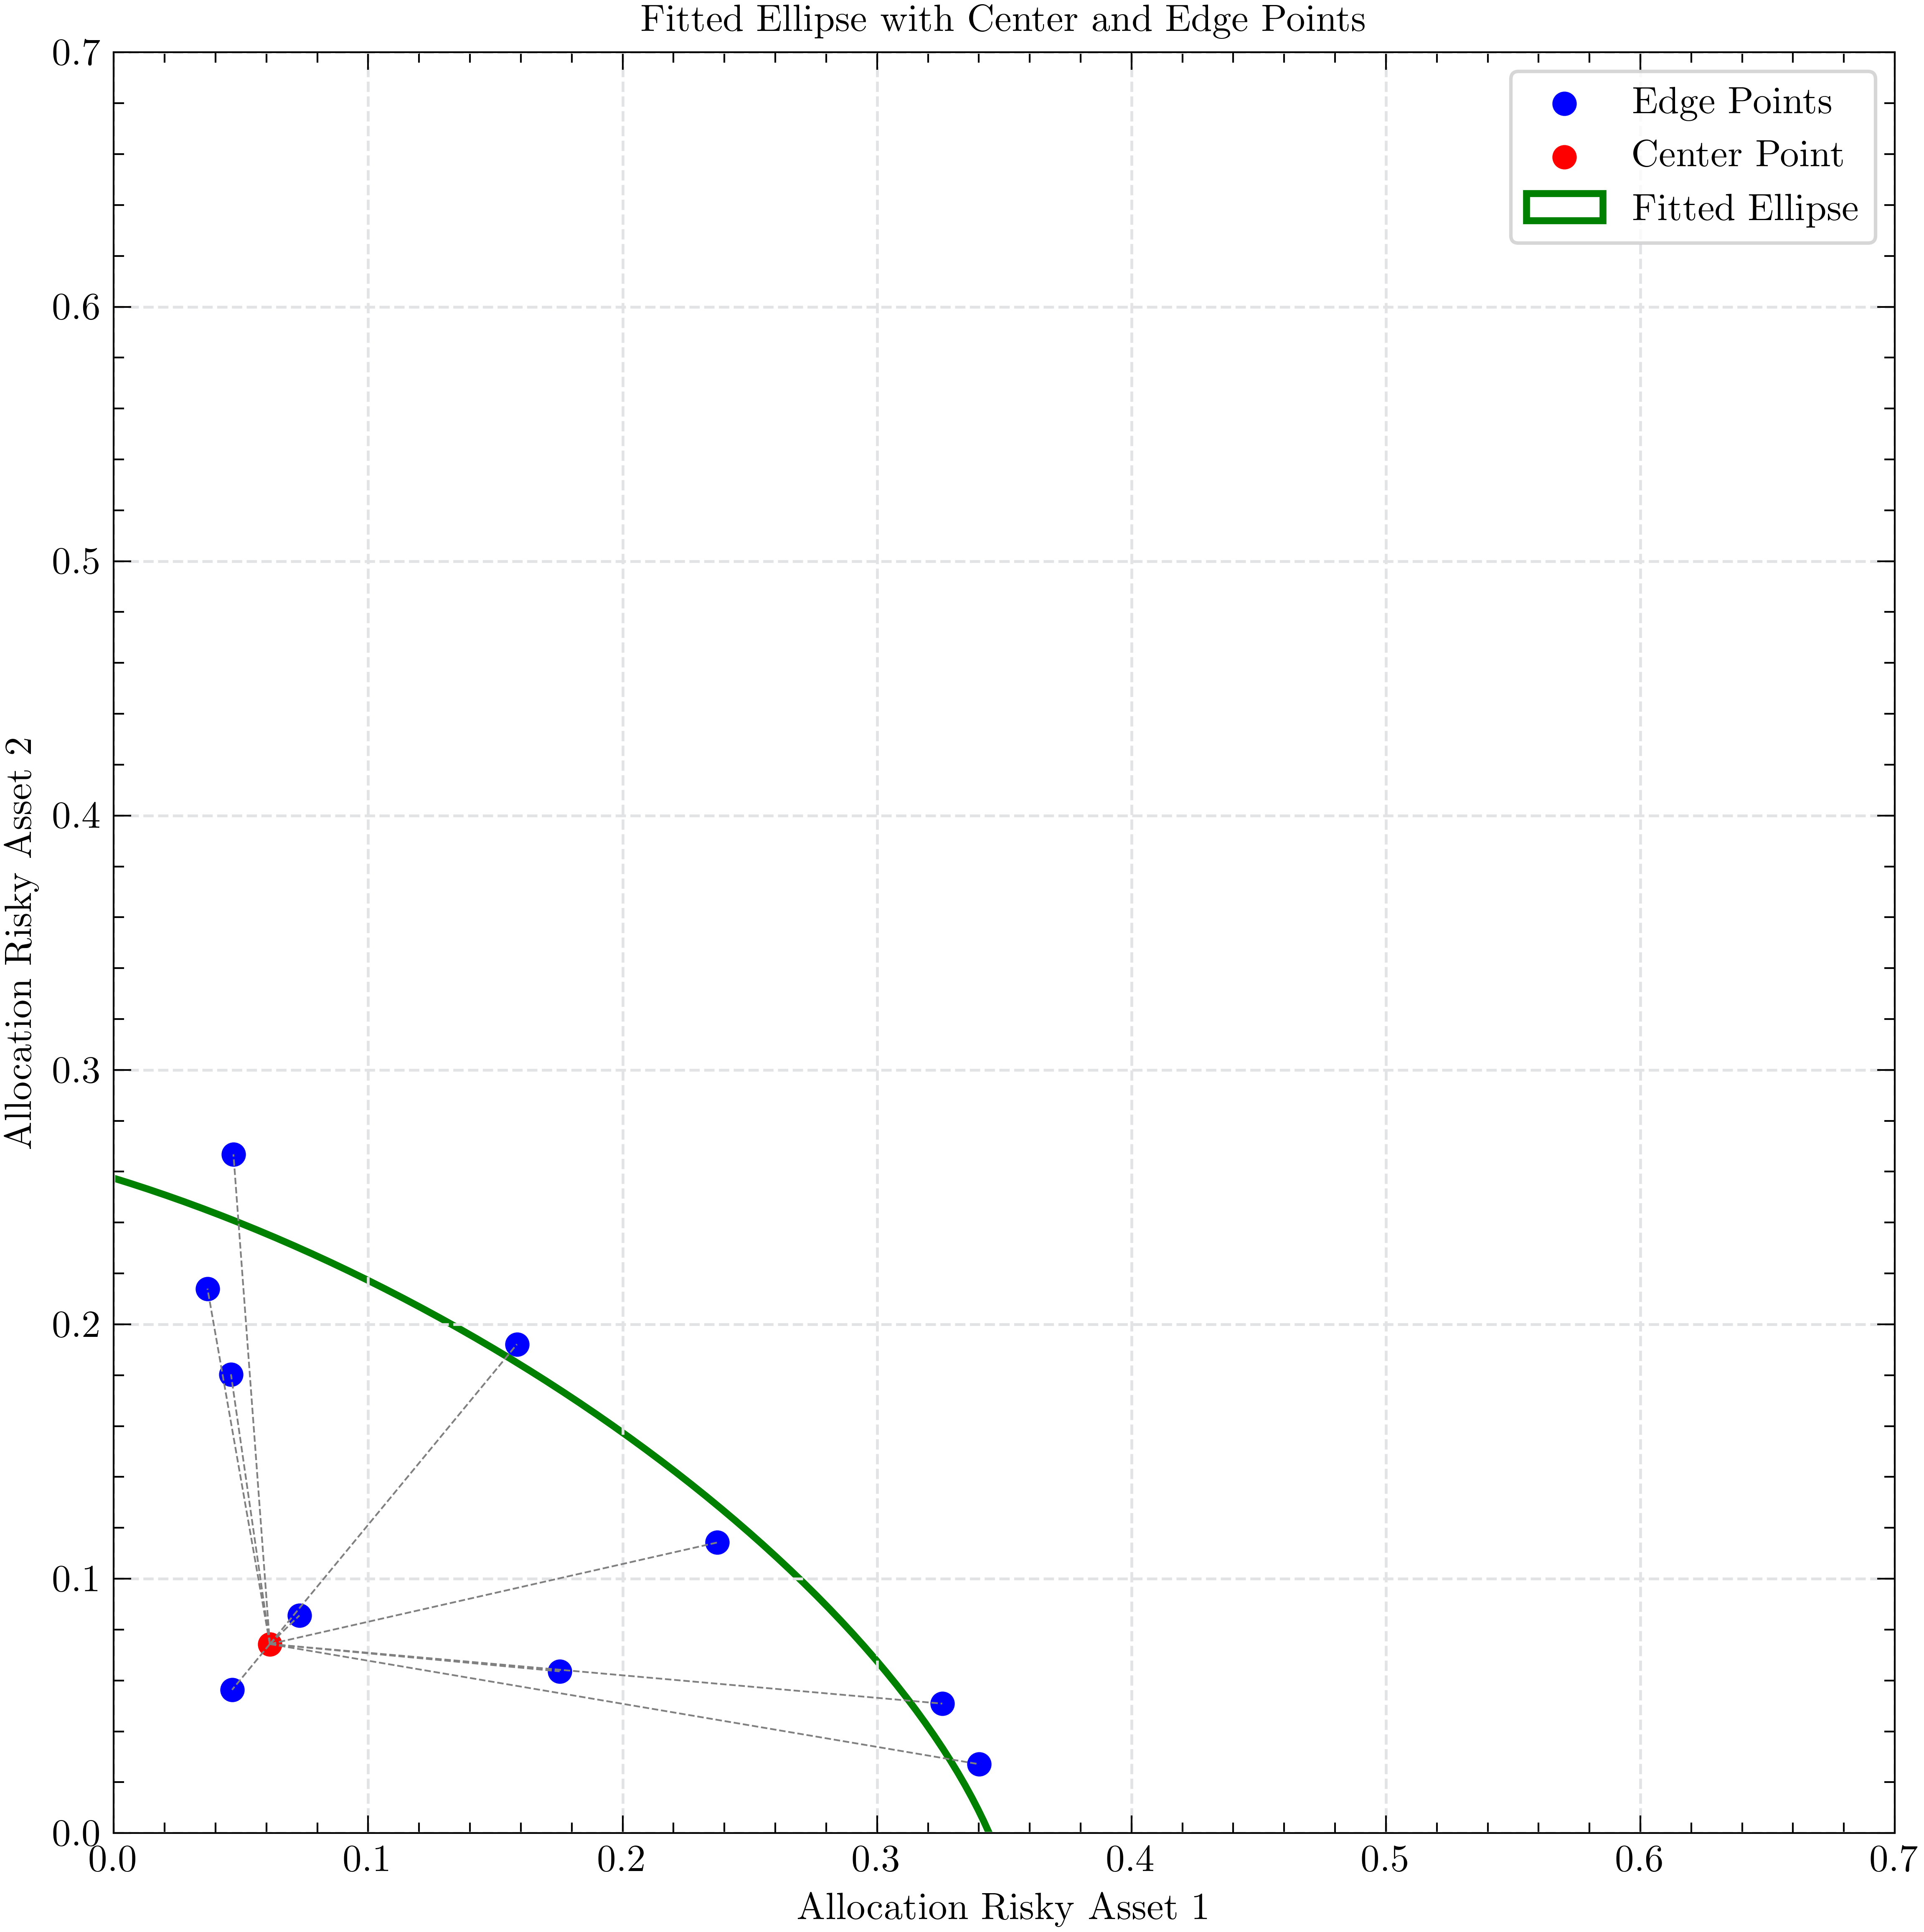

In [12]:
edge_points_array
center_point
A
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_ellipse_with_points(center, A, edge_points):
    """
    Plots the ellipse defined by (x - center)^T A (x - center) = 1,
    the center, the edge points, and lines from edge points to center.

    Args:
        center (np.array): Center of the ellipse, shape (2,)
        A (np.array): Positive definite matrix, shape (2,2)
        edge_points (np.array): Edge points, shape (M,2)
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot edge points
    ax.scatter(edge_points[:, 0], edge_points[:, 1], color='blue', label='Edge Points')
    
    # Plot center point
    ax.scatter(center[0], center[1], color='red', label='Center Point')
    
    # Plot lines from edge points to center
    for point in edge_points:
        ax.plot([center[0], point[0]], [center[1], point[1]], 
                color='gray', linestyle='--', linewidth=0.5)
    
    # Eigen decomposition of A to get ellipse parameters
    eigvals, eigvecs = np.linalg.eigh(A)
    
    # Sort the eigenvalues and eigenvectors
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    
    # Calculate the width and height of the ellipse
    # The lengths of the semi-axes are 1/sqrt(eigvals)
    # Multiply by 2 for the full axis lengths
    width, height = 2 / np.sqrt(eigvals)
    
    # Compute the angle of rotation of the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    
    # Create an Ellipse patch
    ellipse_patch = Ellipse(xy=center, width=width, height=height, angle=angle,
                            edgecolor='green', fc='None', lw=2, label='Fitted Ellipse')
    ax.add_patch(ellipse_patch)
    
    # Set plot attributes
    ax.set_xlabel('Allocation Risky Asset 1')
    ax.set_ylabel('Allocation Risky Asset 2')
    ax.set_title('Fitted Ellipse with Center and Edge Points')
    # set xlim
    ax.set_xlim(0., 0.7)
    ax.set_ylim(0., 0.7)
    ax.set_aspect('equal')
    ax.legend()
    ax.grid(True)
    plt.show()
if D == 2:
    plot_ellipse_with_points(center_point, A, edge_points_array)

# 3d plot of fitting

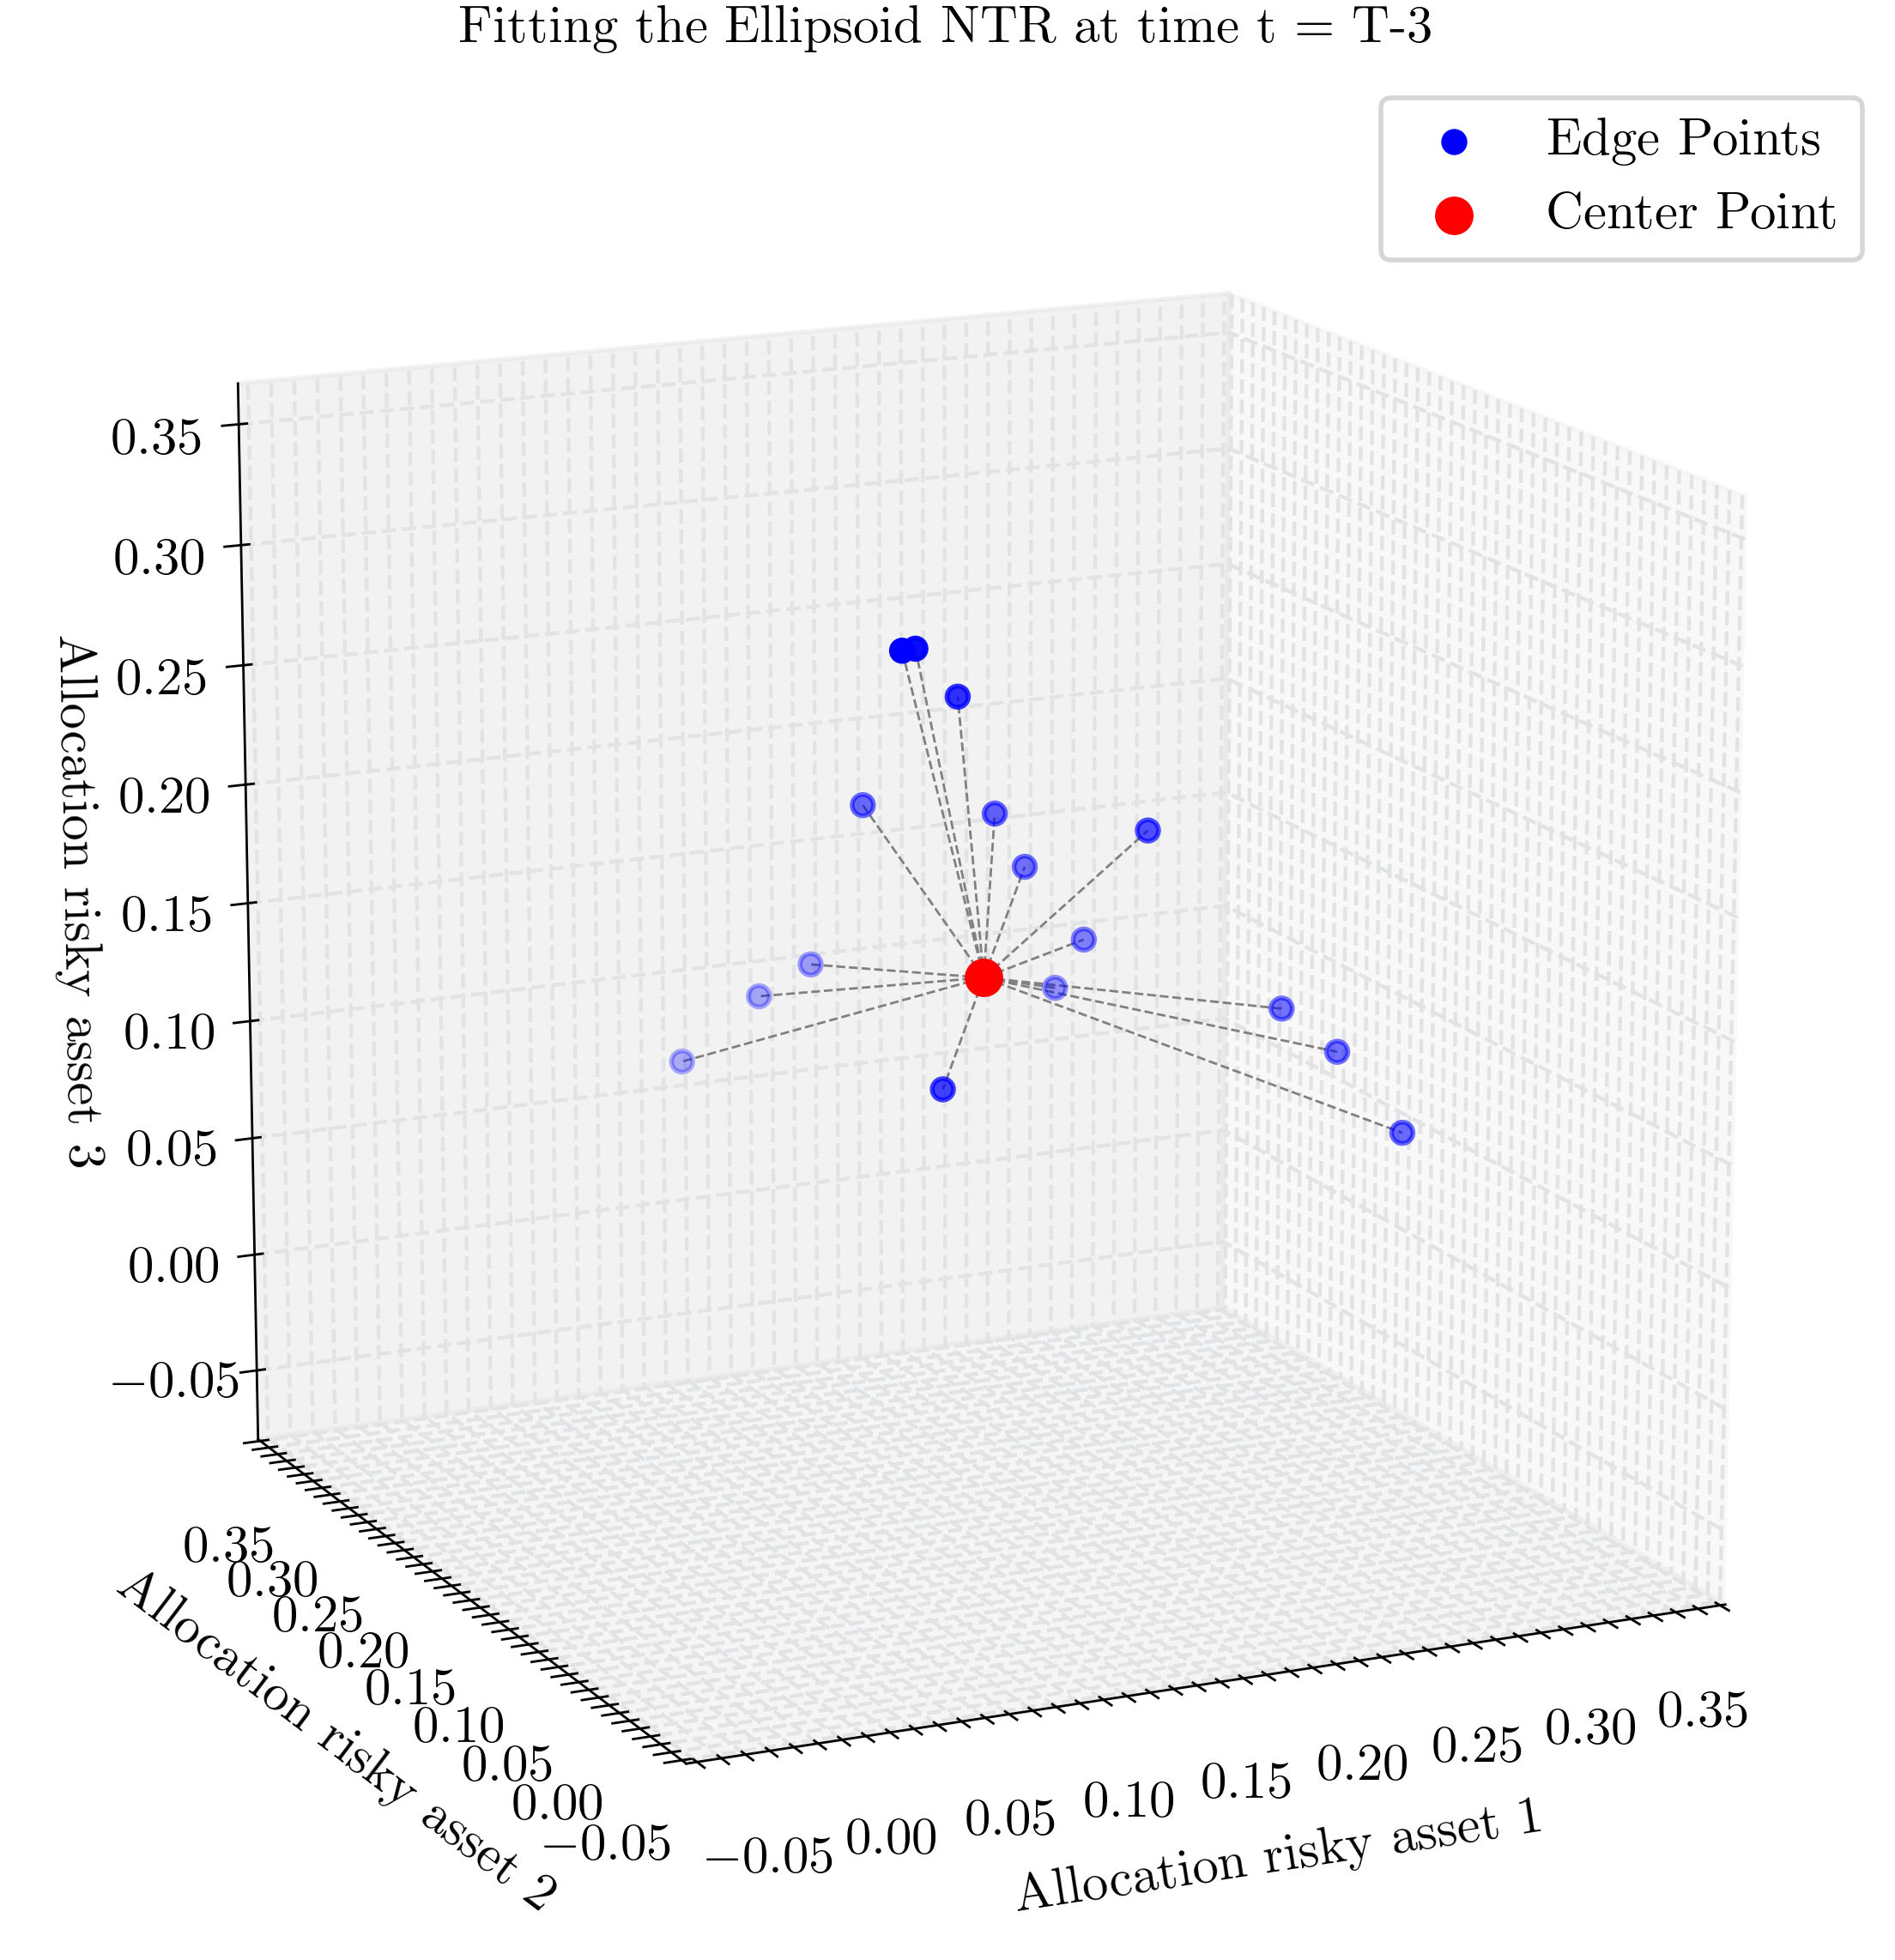

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ellipsoid_with_points(center, A, edge_points):
    """
    Plots the ellipsoid defined by (x - center)^T A (x - center) = 1,
    the center, the edge points, and lines from edge points to center in 3D.

    Args:
        center (np.array): Center of the ellipsoid, shape (3,)
        A (np.array): Positive definite matrix, shape (3,3)
        edge_points (np.array): Edge points, shape (M,3)
    """
    # Ensure the inputs are of correct shape and type
    center = np.asarray(center, dtype=float)
    A = np.asarray(A, dtype=float)
    edge_points = np.asarray(edge_points, dtype=float)

    # Create a 3D figure
    fig = plt.figure(figsize=(8, 6), dpi=400)
    ax = fig.add_subplot(111, projection='3d')

    # Plot edge points
    ax.scatter(edge_points[:, 0], edge_points[:, 1], edge_points[:, 2], color='blue', label='Edge Points')

    # Plot center point
    ax.scatter(center[0], center[1], center[2], color='red', label='Center Point', s=50)

    # Plot lines from edge points to center
    for point in edge_points:
        xs = [center[0], point[0]]
        ys = [center[1], point[1]]
        zs = [center[2], point[2]]
        ax.plot(xs, ys, zs, color='gray', linestyle='--', linewidth=0.5)

    # Eigen decomposition of A
    eigvals, eigvecs = np.linalg.eigh(A)

    # Sort eigenvalues and eigenvectors by decreasing eigenvalue
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # The ellipsoid equation: (x - center)^T A (x - center) = 1
    # If we set y = x - center, then y^T A y = 1
    # Let A = Q diag(eigvals) Q^T, where Q = eigvecs, eigvals = eigenvalues
    # Then y = Q diag(1/sqrt(eigvals)) u, where u is on the unit sphere
    # So to parametrize the ellipsoid:
    # x = center + Q diag(1/sqrt(eigvals)) * [points on unit sphere]

    # Generate a grid of points on a unit sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x_sphere = np.outer(np.cos(u)*np.sin(v), np.ones_like(u))
    y_sphere = np.outer(np.sin(u)*np.sin(v), np.ones_like(u))
    z_sphere = np.outer(np.ones_like(u), np.cos(v)).T  # Make sure dimensions match

    # Now scale the sphere to the ellipsoid
    # diag(1/sqrt(eigvals)) gives the scaling along principal axes
    D = np.diag(1 / np.sqrt(eigvals))
    # Combine the transformations
    # We'll stack the sphere coordinates into a matrix form, transform them, then reshape
    sphere_points = np.stack((x_sphere.flatten(), y_sphere.flatten(), z_sphere.flatten()), axis=1)
    ellipsoid_points = (eigvecs @ D @ sphere_points.T).T + center

    # Reshape into (50, 50) for plotting as a surface
    X = ellipsoid_points[:, 0].reshape(50, 50)
    Y = ellipsoid_points[:, 1].reshape(50, 50)
    Z = ellipsoid_points[:, 2].reshape(50, 50)

    # Plot the ellipsoid surface
    # ax.plot_surface(X, Y, Z, color='green', alpha=0.3, edgecolor='green', label='Fitted Ellipsoid')

    # Set labels and title
    ax.set_xlabel('Allocation risky asset 1')
    ax.set_ylabel('Allocation risky asset 2')
    ax.set_zlabel('Allocation risky asset 3')

    
    ax.set_title('Fitting the Ellipsoid NTR at time t = T-3')

    ax.legend()

    # Optionally set equal aspect ratio for all axes
    # Note: Achieving a perfect equal aspect ratio in 3D can be tricky. One approach:
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range - 0.075, mid_x + max_range + 0.075)
    ax.set_ylim(mid_y - max_range - 0.075, mid_y + max_range + 0.075)
    ax.set_zlim(mid_z - max_range - 0.075, mid_z + max_range + 0.075)
    ax.view_init(elev=15, azim=245)
    ax.set_box_aspect([1.0, 1.0, 1.0])  # Aspect ratio for X, Y, Z      
    plt.tight_layout()
    # plt.savefig('../Speciale dokumentet/Figures/Fitting_Ellipse_NTR_High_Correlation_3_d.png',bbox_inches='tight')
    plt.show()

if D == 3:
    plot_ellipsoid_with_points(center_point, A, edge_points_array)

# 3d plot

/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_21100/668122183.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.plot_surface(X, Y, Z, facecolors=cm.get_cmap(colormap)(norm),


Figure saved to ../Speciale dokumentet/Figures/Fixed_Cost_NTR_Cai_High_Correlation_d3_fc_0.0005__no_consumption_t_3.png


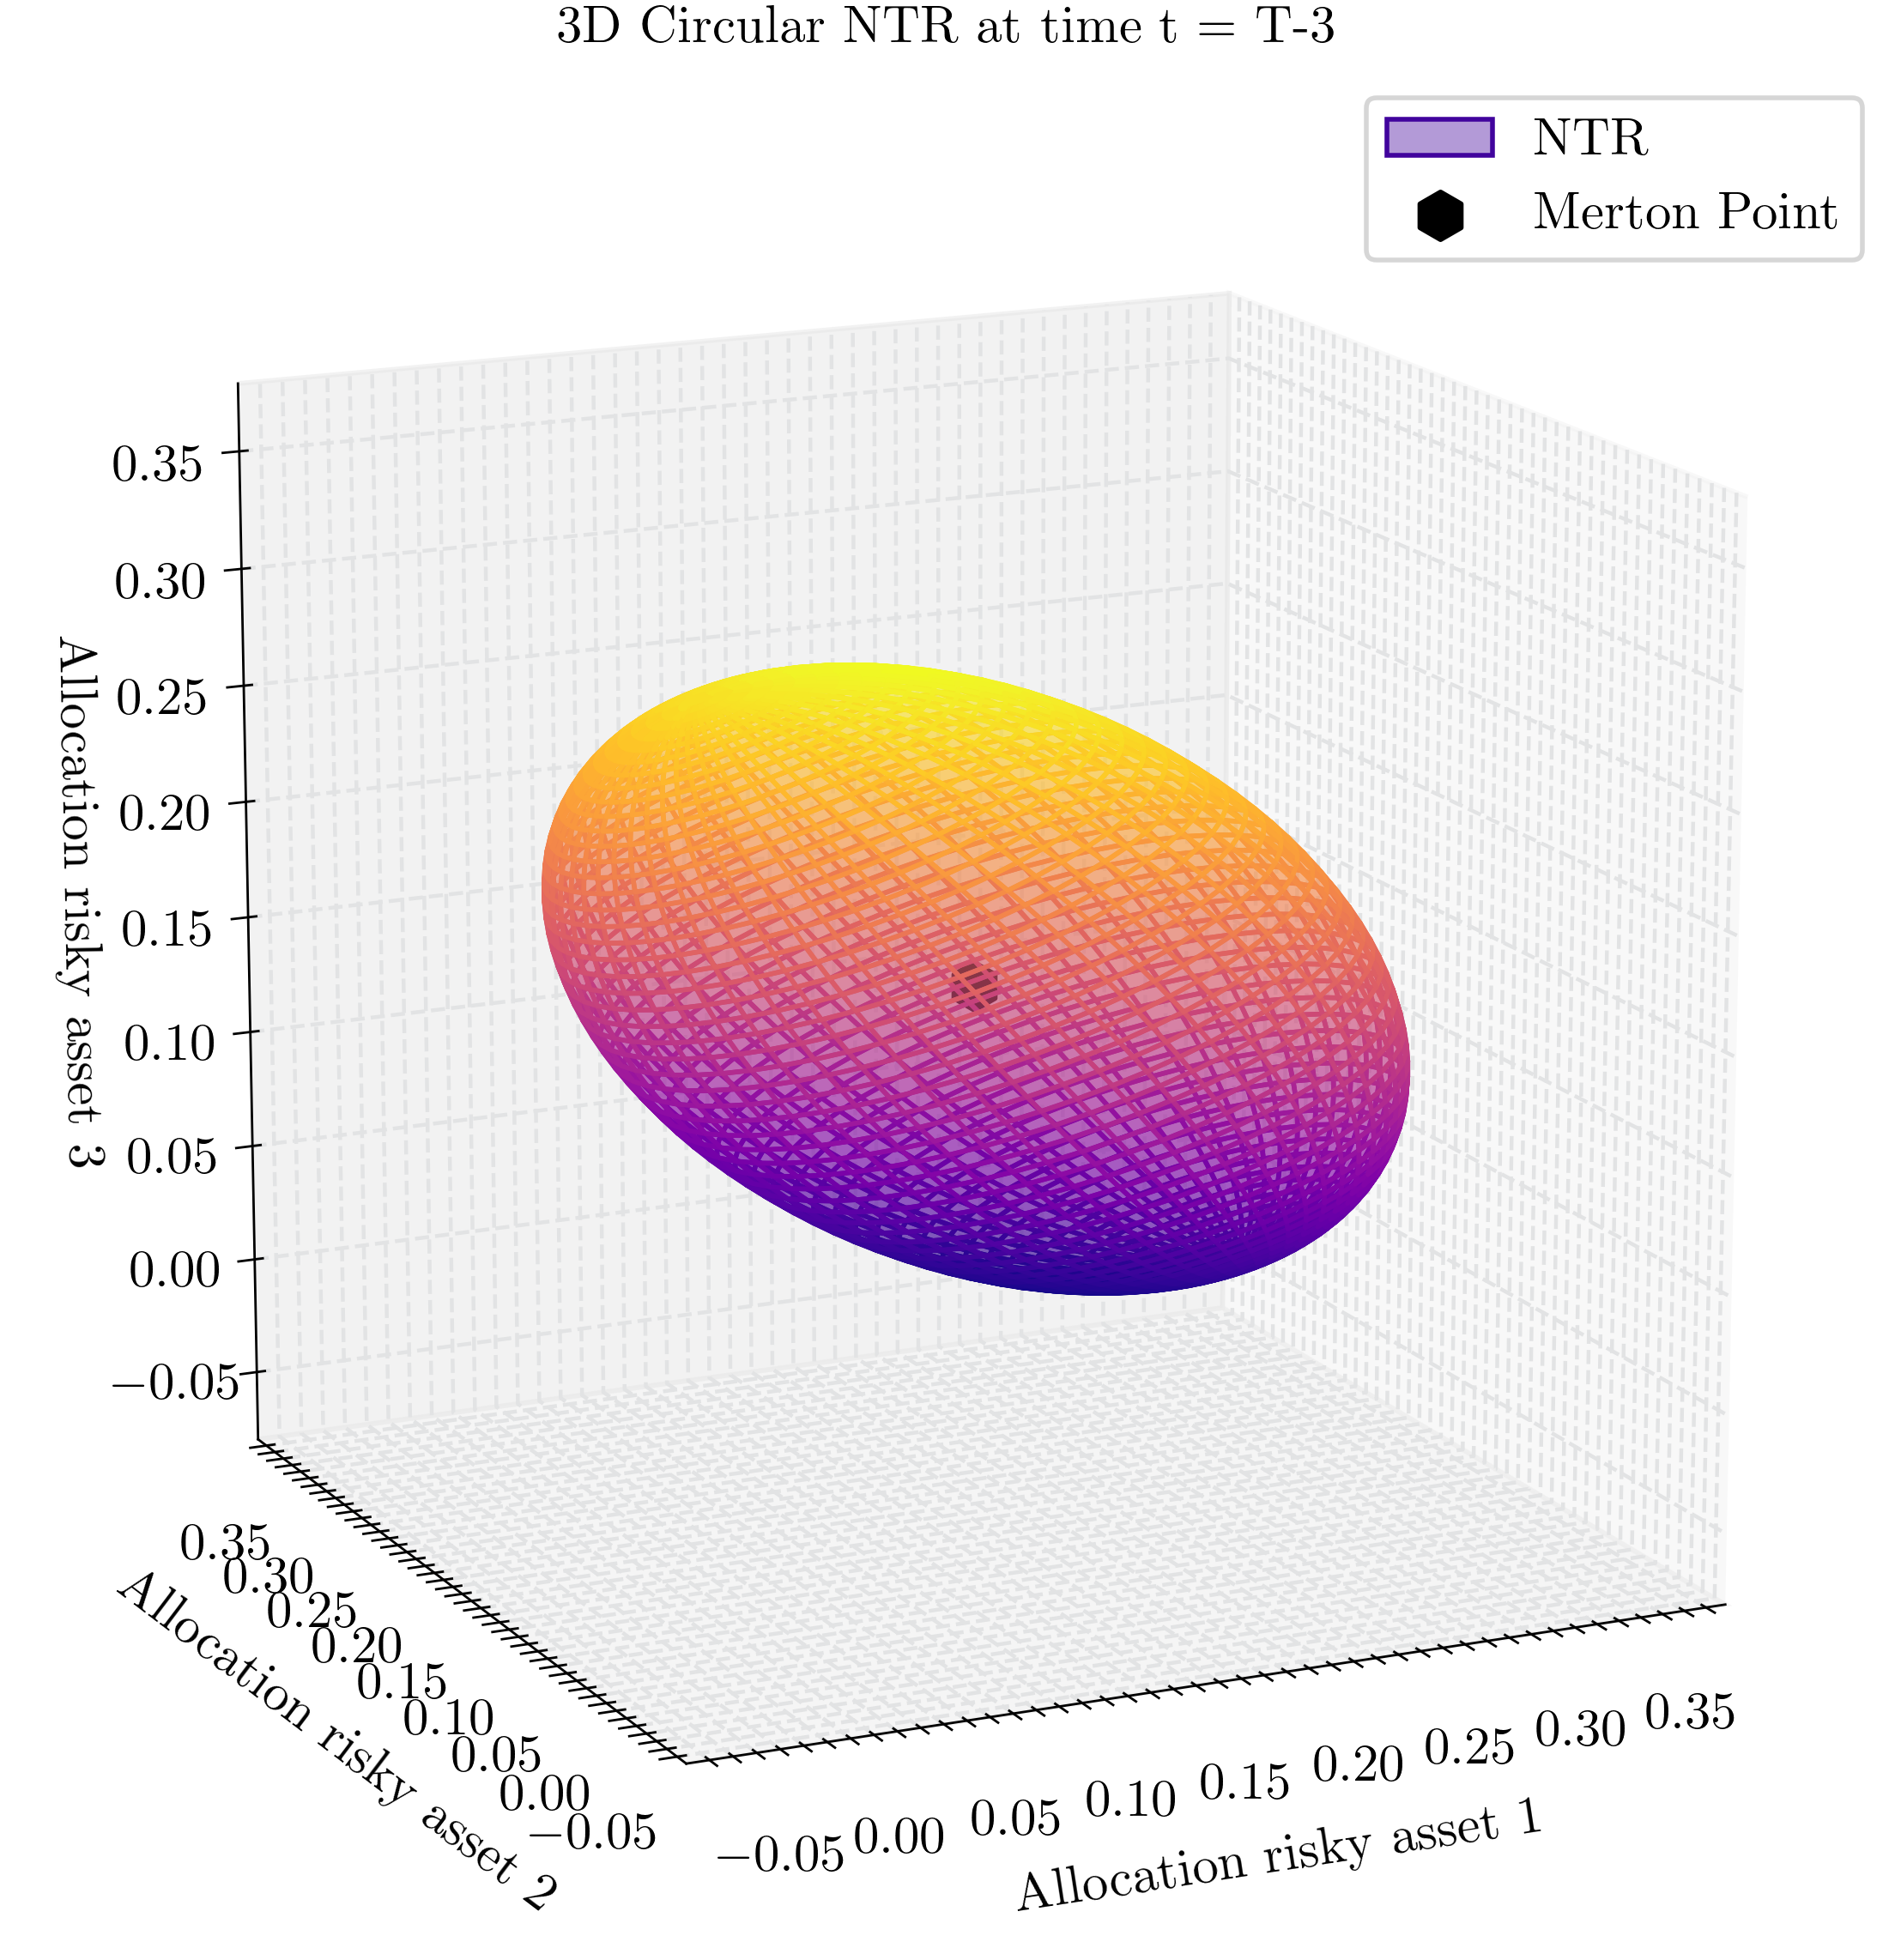

filename is Fixed_Cost_NTR_Cai_High_Correlation_d3_fc_0.0005__no_consumption.pkl


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
t = 3
def plot_ellipsoid_with_colormap(center, A, colormap='plasma', resolution=50,savefigure=False):

    eigvals, eigvecs = np.linalg.eigh(A)
    # Sort eigenvalues descending (just to have a consistent order)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # The ellipsoid axes are given by 1/sqrt(eigvals)
    rx, ry, rz = 1/np.sqrt(eigvals)

    # Parameterization of a unit sphere
    u = np.linspace(0, 2*np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    u, v = np.meshgrid(u, v)

    # Points on a unit sphere
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)

    ellipsoid_coords = np.stack([rx*x, ry*y, rz*z], axis=-1)

    shape = ellipsoid_coords.shape
    ellipsoid_coords_flat = ellipsoid_coords.reshape(-1, 3)
    rotated_coords = ellipsoid_coords_flat @ eigvecs.T
    rotated_coords += center

    # Reshape back
    rotated_coords = rotated_coords.reshape(shape)

    X = rotated_coords[:,:,0]
    Y = rotated_coords[:,:,1]
    Z = rotated_coords[:,:,2]
    
    scalar_field = Z

    # Normalize the scalar field for colormap
    sf_min, sf_max = scalar_field.min(), scalar_field.max()
    norm = (scalar_field - sf_min) / (sf_max - sf_min)

    fig = plt.figure(figsize=(8,6),dpi=400)
    ax = fig.add_subplot(111, projection='3d')

    # Create a colormap surface
    ax.plot_surface(X, Y, Z, facecolors=cm.get_cmap(colormap)(norm), 
                    rcount=resolution, ccount=resolution, shade=False,zorder=1,alpha=0.4,
                    label='NTR')
    
    # Highlight the Merton point and add a stem
    ax.scatter(
        merton_p[0], merton_p[1], merton_p[2], marker='h',
        color='black', s=100, label='Merton Point', zorder=5
    )

    # Set labels
    ax.set_xlabel('Allocation risky asset 1')
    ax.set_ylabel('Allocation risky asset 2')
    ax.set_zlabel('Allocation risky asset 3')
    ax.set_title('3D Circular NTR at time t = T-3')
    
    # Make the aspect ratio equal for all axes
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range - 0.075, mid_x + max_range + 0.075)
    ax.set_ylim(mid_y - max_range - 0.075, mid_y + max_range + 0.075)
    ax.set_zlim(mid_z - max_range - 0.075, mid_z + max_range + 0.075)
    ax.view_init(elev=15, azim=245)
    ax.set_box_aspect([1.0, 1.0, 1.0])  # Aspect ratio for X, Y, Z                           
    ax.legend()
    if savefigure:
        save_figure_with_filename(filename[:-4], t, output_folder='../Speciale dokumentet/Figures')
    plt.show()

plot_ellipsoid_with_colormap(center_point, A, colormap='plasma', resolution=60,savefigure=True)
print(f"filename is {filename}")

# Select dimensions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_ellipsoid_with_colormap(center, A, colormap='plasma', resolution=50, dimensions=None, savefigure=False):
    """
    Plots an ellipsoid given its center and matrix A. Supports plotting 2D or 3D projections for higher dimensions.

    Args:
        center (array-like): Center of the ellipsoid.
        A (array-like): Symmetric positive-definite matrix defining the ellipsoid.
        colormap (str): Name of the matplotlib colormap.
        resolution (int): Resolution for the ellipsoid surface.
        dimensions (list): List of dimensions to plot. If None, plots all dimensions.
        savefigure (bool): Whether to save the figure.
    """
    n = len(center)
    if dimensions is None:
        dimensions = list(range(n))
    elif len(dimensions) < 2 or len(dimensions) > 3:
        raise ValueError("Can only plot 2D or 3D projections.")

    eigvals, eigvecs = np.linalg.eigh(A)
    # Sort eigenvalues descending for consistency
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # Ellipsoid axes
    axes_lengths = 1 / np.sqrt(eigvals)
    
    # Parameterization of a unit sphere
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    u, v = np.meshgrid(u, v)
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    sphere_coords = np.stack([x, y, z], axis=-1)  # Unit sphere coordinates
    ellipsoid_coords = sphere_coords * axes_lengths  # Scale by ellipsoid axes
    ellipsoid_coords = ellipsoid_coords @ eigvecs.T  # Rotate by eigvecs
    ellipsoid_coords += center  # Translate to center

    # Select specified dimensions
    selected_coords = ellipsoid_coords[..., dimensions]

    # Plot
    if len(dimensions) == 2:
        X = selected_coords[..., 0]
        Y = selected_coords[..., 1]
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, np.sqrt(X**2 + Y**2), cmap=colormap, levels=resolution)
        plt.xlabel(f'Dimension {dimensions[0]}')
        plt.ylabel(f'Dimension {dimensions[1]}')
        plt.title('2D Ellipsoid Projection')
        plt.colorbar(label='Scalar field')
        plt.axis('equal')
        plt.show()

    elif len(dimensions) == 3:
        X = selected_coords[..., 0]
        Y = selected_coords[..., 1]
        Z = selected_coords[..., 2]
        scalar_field = Z
        sf_min, sf_max = scalar_field.min(), scalar_field.max()
        norm = (scalar_field - sf_min) / (sf_max - sf_min)

        fig = plt.figure(figsize=(8, 6), dpi=400)
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, facecolors=cm.get_cmap(colormap)(norm),
                        rcount=resolution, ccount=resolution, shade=False, alpha=0.4)
        ax.set_xlabel(f'Dimension {dimensions[0]}')
        ax.set_ylabel(f'Dimension {dimensions[1]}')
        ax.set_zlabel(f'Dimension {dimensions[2]}')
        ax.set_title('3D Ellipsoid Projection')
        ax.view_init(elev=15, azim=120)
        plt.show()

plot_ellipsoid_with_colormap(center_point, A, dimensions=[0, 1, 2])  # Plot 3D projection
plot_ellipsoid_with_colormap(center_point, A, dimensions=[0, 1])  # Plot 2D projection

# Plot the sampling 

In [ ]:
t = 5
points_inside_ntr, points_around_kinks, points_outside_ntr = sample_points_around_ntr_separated(NTR[t],2, N,seed=12012001+t)

# Save Non-Naive sampling strategy plot
plt.figure(figsize=(8, 6))

plt.scatter(points_outside_ntr[:, 0], points_outside_ntr[:, 1], label='General State Space', color=colors[0])
plt.scatter(points_inside_ntr[:, 0], points_inside_ntr[:, 1], label='Inside NTR', color=colors[1])
plt.scatter(points_around_kinks[:, 0], points_around_kinks[:, 1], label='Around Kinks', color=colors[2] )
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
# plt.savefig(os.path.join(output_folder, 'Fixed_Costs_sampling_strategy.png'))
# plt.close()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def fit_fixed_center_ellipse_with_radii(points, center, radii):
    """
    Fits an ellipse to a set of edge points with a fixed center and known radii.

    Args:
        points (array-like): Array of shape (N, 2) containing x, y coordinates.
        center (tuple): (x_c, y_c), the fixed center of the ellipse.
        radii (array-like): Array of distances between the center and the edge points.

    Returns:
        dict: Fitted ellipse parameters {A, B, C}.
    """
    X = points[:, 0] - center[0]
    Y = points[:, 1] - center[1]

    # Construct the design matrix
    M = np.vstack([X**2, X * Y, Y**2]).T

    # Objective function: Minimize the residuals of the ellipse equation
    def objective(params):
        A, B, C = params
        ellipse_values = A * X**2 + B * X * Y + C * Y**2 - 1
        return np.sum(ellipse_values**2)

    # Constraint: B^2 - 4AC < 0 for a valid ellipse
    def constraint(params):
        A, B, C = params
        return B**2 - 4 * A * C - 1e-8  # Slight margin to ensure strict inequality

    # Solve the optimization problem
    initial_params = [1, 0, 1]  # Initial guess for A, B, C
    constraints = {'type': 'ineq', 'fun': lambda params: -constraint(params)}  # Enforce B^2 - 4AC < 0
    result = minimize(objective, initial_params, constraints=constraints, method='SLSQP')

    if not result.success:
        raise ValueError("Ellipse fitting failed. Try with different points or settings.")

    A, B, C = result.x
    return {'A': A, 'B': B, 'C': C}

def compute_angles_from_points(points, center):
    """
    Computes angles between the center and edge points.

    Args:
        points (array-like): Array of shape (N, 2) containing x, y coordinates.
        center (tuple): (x_c, y_c), the fixed center of the ellipse.

    Returns:
        np.array: Array of angles in radians.
    """
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    return angles

def plot_fixed_center_ellipse_with_radii(params, center, points, radii, num_points=500):
    """
    Plots a valid ellipse given its parameters and a fixed center, showing the edge points and radii.

    Args:
        params (dict): Ellipse parameters {A, B, C}.
        center (tuple): (x_c, y_c), the fixed center of the ellipse.
        points (array-like): The original points used to fit the ellipse.
        radii (array-like): Array of distances between the center and the edge points.
        num_points (int): Number of points to sample for the ellipse.
    """
    A, B, C = params.values()
    x_c, y_c = center

    # Generate angles and parametric points
    theta = np.linspace(0, 2 * np.pi, num_points)
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    # Parametric equation for the ellipse
    denom = np.sqrt((C * cos_t**2 + B * cos_t * sin_t + A * sin_t**2))
    x = x_c + cos_t / denom
    y = y_c + sin_t / denom

    # Plot the ellipse
    plt.figure(figsize=(6, 6))
    plt.plot(x, y, color='blue', label="Fitted Ellipse")
    plt.scatter(points[:, 0], points[:, 1], color='red', label="Edge Points")
    plt.scatter(x_c, y_c, color='green', label="Fixed Center")
    for i, point in enumerate(points):
        plt.plot([center[0], point[0]], [center[1], point[1]], 'k--', linewidth=0.5)
        plt.text(point[0], point[1], f"R={radii[i]:.2f}", color='black', fontsize=8)
    plt.title("Fitted Ellipse with Fixed Center and Radii")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

# Example usage
center = [0.33, 0.33]
edge_points = np.array([[0.2384 , 0.2384], [0.2715 , 0.4488], [0.4215 , 0.4215], [0.448 , 0.2715]])
radii = np.linalg.norm(edge_points - center, axis=1)  # Compute distances to the center

# Compute angles (for reference)
angles = compute_angles_from_points(edge_points, center)
for i, angle in enumerate(angles):
    print(f"Edge Point: {edge_points[i]}, Radius: {radii[i]:.2f}, Angle: {np.degrees(angle):.2f} degrees")

# Fit the ellipse and plot it
try:
    params = fit_fixed_center_ellipse_with_radii(edge_points, center, radii)
    plot_fixed_center_ellipse_with_radii(params, center, edge_points, radii)
except ValueError as e:
    print("Error:", e)

In [ ]:
t = 5
points = NTR_points[t]#[:120]

# Prepare lists to store original points and solution points
original_points = []
solution_points = []

for (x, omega) in points:
    original_points.append(x)
    # omega has shape (1, D), so we take the first (and only) row
    solution_points.append(omega[0])

original_points = np.array(original_points)  # Shape: (num_points, D)
solution_points = np.array(solution_points)  # Shape: (num_points, D)

In [ ]:
1/0
def save_figure_with_filename(base_filename, t, output_folder='../Speciale dokumentet/Figures'):
    """
    Saves the figure with the given filename structure and adds '_t_{t}'.

    Parameters:
    - base_filename: The base filename to use.
    - t: The time period to append to the filename.
    - output_folder: The folder to save the figure in.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the full filename
    figure_filename = f"{base_filename}_t_{t}.png"
    full_path = os.path.join(output_folder, figure_filename)
    # Force the rendering of the current figure (important for 3D plots)
    plt.gcf().canvas.draw()

    # Save the figure
    plt.savefig(full_path, bbox_inches='tight')
    print(f"Figure saved to {full_path}")


# Choose the parameter prefix based on the active parameter set
if Schober_Parameters:
    filename_prefix = "Fixed_Schober_Parameters"
elif Cai_Judd_Identical:
    filename_prefix = "Fixed_Cai_Identical"
elif Cai_Judd_High_Correlation:
    filename_prefix = "Fixed_Cai_High_Correlation"
else:
    filename_prefix = "Fixed_Unknown_Parameters"

if include_consumption:
    consumption = "_with_consumption"
else:
    consumption = "_no_consumption"

# Construct the full file path
filename = f"{filename_prefix}"

# Select the specific time period
t = 5
points = NTR_points[t]#[:120]

# Prepare lists to store original points and solution points
original_points = []
solution_points = []

for (x, omega) in points:
    original_points.append(x)
    # omega has shape (1, D), so we take the first (and only) row
    solution_points.append(omega[0])

original_points = np.array(original_points)  # Shape: (num_points, D)
solution_points = np.array(solution_points)  # Shape: (num_points, D)

# Calculate the distances between corresponding points
distances = np.linalg.norm(original_points - solution_points, axis=1)

# Set the threshold for nearly identical points
threshold = 1e-6

# Find the indices of nearly identical points
matching_indices = np.where(distances <= threshold)[0]

# Retrieve matching points
matching_original_points = original_points[matching_indices]
matching_solution_points = solution_points[matching_indices]

# Display results
matching_indices, matching_original_points, matching_solution_points

# Create the plot
plt.figure(figsize=(8, 6),dpi=400)

# Plot original points
plt.scatter(original_points[:, 0], original_points[:, 1], s = 0.5, label='Starting Points', alpha=0.3, marker='.', color=colors[2],zorder=2)

# Plot solution points
plt.scatter(solution_points[:, 0], solution_points[:, 1], s = 0)

plt.scatter(matching_original_points[:, 0], matching_original_points[:, 1], s = 4, label='NTR points', color=colors[1], alpha=1.0, marker='.',zorder=4)

plt.scatter(merton_p[0], merton_p[1], s = 50, label='Merton Point', color=colors[3], alpha=1.0, marker='o',zorder=5)

# Draw lines connecting original points to their solutions
for i in range(len(points)):
    if i == 0:
        plt.plot(
            [original_points[i, 0], solution_points[i, 0]],
            [original_points[i, 1], solution_points[i, 1]],
            color=colors[0], linestyle='-', linewidth=1.0, alpha = 0.05, zorder=3, label='Rebalancing trajectory'
        )
    else: 
        plt.plot(
            [original_points[i, 0], solution_points[i, 0]],
            [original_points[i, 1], solution_points[i, 1]],
            color=colors[0], linestyle='-', linewidth=1.0, alpha = 0.05, zorder=3, #if i == 0 label='Rebalancing trajectory'
        )

# Enhancements
plt.title(f'Portfolio Optimization at time Period t=T-1')
plt.xlabel('Allocation risky asset 1')
plt.ylabel('Allocation risky asset 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
save_figure_with_filename('Verify_NTR_Fixed'+filename,t)

# Show the plot
plt.show()

### Save the NTR

In [11]:
filename_prefix

'Schober_Parameters'

In [12]:
def save_ntr_array_to_file(NTR, filename_prefix, D, fc,include_consumption):
    """
    Saves the NTR array to a file with a dynamically generated name using pickle in the "NTRs" folder.

    Parameters:
    - NTR: List of ConvexHull objects (or None).
    - filename_prefix: A string to indicate the parameter set (e.g., "Schober_Parameters").
    - D: The number of assets (dimensionality).
    - tau: The transaction cost rate.

    The file will be named `NTR_<filename_prefix>_d<D>_tau_<tau>.pkl` and saved in the "NTRs" folder.
    """
    # Ensure the "NTRs" folder exists
    os.makedirs("NTRs", exist_ok=True)

    if include_consumption:
        consumption = "_with_consumption"
    else:
        consumption = "_no_consumption"

    # Construct the full file path
    # filename = f"NTRs/NTR_{filename_prefix}_d{D}_tau_{tau}_{consumption}.pkl"
    filename = f"NTRs/Fixed_Cost_NTR_{filename_prefix}_{D}d_fc_{fc}_{consumption}.pkl"

    # Save the NTR array using pickle
    with open(filename, "wb") as file:
        pickle.dump(NTR, file)
    print(f"NTR array saved to {filename}")

def load_ntr_array_from_file(filename):
    """
    Loads the NTR array from a pickle file.

    Parameters:
    - filename: The name of the file to load.

    Returns:
    - The NTR array (list of ConvexHull objects or None).
    """
    # Ensure the "NTRs" folder exists
    os.makedirs("NTRs", exist_ok=True)

    # Construct the full file path
    full_filename = os.path.join("NTRs", filename)

    with open(full_filename, "rb") as file:
        NTR = pickle.load(file)
    print(f"NTR array loaded from {full_filename}")
    return NTR

# Choose the parameter prefix based on the active parameter set
# Choose the parameter prefix based on the active parameter set
if Schober_Parameters:
    filename_prefix = "Fixed_Schober_Parameters"
elif Cai_Judd_Identical:
    filename_prefix = "Fixed_Cai_Identical"
elif Cai_Judd_High_Correlation:
    filename_prefix = "Fixed_Cai_High_Correlation"
else:
    filename_prefix = "Fixed_Unknown_Parameters"


save_ntr_array_to_file(NTR, filename_prefix, D, fc,include_consumption)
# NTR = load_ntr_array_from_file(f"NTR_Cai_Identical_d2_tau_0.001__no_consumption.pkl")

NTR array saved to NTRs/Fixed_Cost_NTR_Fixed_Schober_Parameters_3d_fc_0.0005__no_consumption.pkl


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(4,3),dpi=200)

        if D == 2:
            # 2D plot
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[1], alpha=0.2,label='NTR')
            plt.title(f'NTR at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point')
            plt.legend()
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)

        elif D == 3:
                # 3D plot
                ax = plt.axes(projection='3d')
                ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color=colors[1],alpha=0.2,s=10,marker='*')
                
                # Plot only the convex hull surfaces without edges
                faces = hull.simplices
                poly3d = [[vertices[face] for face in simplex] for simplex in faces]
                ax.add_collection3d(Poly3DCollection(poly3d, facecolors=colors[4], edgecolor='none', alpha=0.2))
                
                ax.scatter(merton_p[0], merton_p[1], merton_p[2], color=colors[0], s=75, label='Merton Point')
                ax.legend()
                ax.set_xlabel('State dimension 1')
                ax.set_ylabel('State dimension 2')
                ax.set_zlabel('State dimension 3')
                plt.title(f'NTR at time {t}')
                x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
                y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
                z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()
                ax.set_xlim(x_min - 0.05, x_max + 0.05)
                ax.set_ylim(y_min - 0.05, y_max + 0.05)
                ax.set_zlim(z_min - 0.05, z_max + 0.05)  
                ax.view_init(elev=25, azim=305)  # Adjust elev and azim for desired viewing angle

        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1
plot_ntr_at_time(NTR,int(T/Delta_t)-5)